In [1]:
import os
import re
import spacy
import pandas as pd
import logging

# import requirements for converting the dataframe to Spacy Docs
from collections import defaultdict
from unicodedata import normalize
import regex
import random

# Get the root logger
logger = logging.getLogger()

# Remove all handlers from the logger
for handler in logger.handlers[:]:
    logger.removeHandler(handler)

# Add a new handler to the logger
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(name)s - %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)

logger.setLevel(logging.DEBUG)


In [2]:
# config.py

class Config:
    DEFAULT_FORM = 'NFKD'
    REMOVE_ACCENTS = False
    LOWERCASE = False
    STANDARDIZE_APOSTROPHE = True
    REMOVE_BRACKETS = False
    REMOVE_TRAILING_NUMBERS = False
    REMOVE_EXTRA_SPACES = False
    DEBUG = False

# Instantiating the Config class for application-wide access.
app_config = Config()

import re
import unicodedata

# apostrophes and correct_apostrophe are defined as follows:
apostrophes = ["᾽", "᾿", "'", "’", "‘"]
correct_apostrophe = "ʼ"

def clean_and_remove_accents(text: str) -> str:
    """
    Cleans the given text by removing diacritics (accents), except for specific characters,
    and converting it to lowercase.
    """
    allowed_characters = [' ̓', "᾿", "᾽", "'", "’", "‘", 'ʼ', '̓']  # Including the Greek apostrophe
    if not isinstance(text, str):
        raise ValueError("Input must be a string.")
    try:
        non_accent_chars = [c for c in unicodedata.normalize('NFKD', text) 
        if unicodedata.category(c) != 'Mn' or c in allowed_characters]
        return ''.join(non_accent_chars)
    
    except Exception as e:
        # A more generic exception handling if unexpected errors occur
        print(f"An error occurred: {e}")
        return text
    

def normalize_text(text: str, 
                   form: str = None, 
                   remove_accents: bool = None, 
                   lowercase: bool = None, 
                   standardize_apostrophe: bool = None, 
                   remove_brackets: bool = None, 
                   remove_trailing_numbers: bool = None, 
                   remove_extra_spaces: bool = None, 
                   debug: bool = None) -> str:
    """
    Applies multiple text normalization and cleaning steps on the input text.

    Parameters:
    - text (str): The text to be normalized.
    - form (str): Unicode normalization form ('NFC', 'NFD', 'NFKC', 'NFKD').
    - remove_accents (bool): If True, removes accents from the text.
    - lowercase (bool): If True, the text is converted to lowercase.
    - standardize_apostrophe (bool): If True, replaces all defined apostrophe characters with a standard one.
    - remove_brackets_only (bool): If True, removes the brackets themselves.
    - remove_trailing_numbers (bool): If True, strips leading or trailing digits from the text.
    - remove_extra_spaces (bool): If True, removes extra spaces and leading/trailing spaces.
    - debug (bool): If True, prints before and after states for each operation.
    
    Returns:
    - str: The processed text.
    """
    
    # Fetch default settings from app_config if not provided
    form = form if form is not None else app_config.DEFAULT_FORM
    remove_accents = remove_accents if remove_accents is not None else app_config.REMOVE_ACCENTS
    lowercase = lowercase if lowercase is not None else app_config.LOWERCASE
    standardize_apostrophe = standardize_apostrophe if standardize_apostrophe is not None else app_config.STANDARDIZE_APOSTROPHE
    remove_brackets = remove_brackets if remove_brackets is not None else app_config.REMOVE_BRACKETS
    remove_trailing_numbers = remove_trailing_numbers if remove_trailing_numbers is not None else app_config.REMOVE_TRAILING_NUMBERS
    remove_extra_spaces = remove_extra_spaces if remove_extra_spaces is not None else app_config.REMOVE_EXTRA_SPACES
    debug = debug if debug is not None else app_config.DEBUG
    
    normalized_text = text  # Initialize normalized_text with the original text

    # Function to print before and after states for each operation during debugging
    def debug_print(operation_name, before, after):
        if debug:
            logger.debug(f"{operation_name} - Before: {before}")
            logger.debug(f"{operation_name} - After: {after}")

    # Standardize apostrophe characters if required
    if standardize_apostrophe:
        before_text = normalized_text
        for apos in apostrophes:
            normalized_text = normalized_text.replace(apos, correct_apostrophe)
        debug_print("Standardizing apostrophes", before_text, normalized_text)
        
    if remove_accents:
        before_text = normalized_text
        try:
            normalized_text = clean_and_remove_accents(normalized_text)
        except Exception as e:
            logger.error(f"An error occurred while removing accents: {e}")
            # Decide what to do here: return the original text, a special value, or stop the process
            return text        
        debug_print("Removing accents", before_text, normalized_text)
        
    # Convert to lowercase if required
    if lowercase:
        before_text = normalized_text
        normalized_text = normalized_text.lower()
        debug_print("Lowercase conversion", before_text, normalized_text)

    # Unicode normalization
    if form:
        before_text = normalized_text
        normalized_text = unicodedata.normalize(form, normalized_text)
        debug_print("Unicode normalization", before_text, normalized_text)
            
    # Remove brackets only if required
    if remove_brackets:
        before_text = normalized_text
        normalized_text = re.sub(r'[\(\)\[\]]', '', normalized_text)
        debug_print("Removing brackets", before_text, normalized_text)
        
    # Remove trailing numbers if required
    if remove_trailing_numbers:
        before_text = normalized_text
        normalized_text = re.sub(r'^\d+|\d+$', '', normalized_text)
        debug_print("Removing trailing numbers", before_text, normalized_text)

    # Remove multiple spaces and leading/trailing spaces
    if remove_extra_spaces:
        before_text = normalized_text
        normalized_text = ' '.join(normalized_text.split()).strip()
        debug_print("Removing extra spaces", before_text, normalized_text)

    return normalized_text

# Load and process data from Coda

In [3]:

# Load the dataset
FILE_PATH = "../assets/NER_assets/Ancient_Words_12_5_22.csv"
df = pd.read_csv(FILE_PATH)

# Renaming columns
df.rename(columns={'Word': 'Keyword', 'Category Types': 'Label'}, inplace=True)

# Filling NaN values more efficiently and appropriately
for early_col, new_col in [('Early Quote', 'Quote'), ('Early Word Before', 'Word Before'), 
                           ('Early Word After', 'Word After'), ('Early Category Type', 'Label')]:
    df[new_col].fillna(df[early_col], inplace=True)

# Dropping rows with no Keyword and non-Greek Keywords
pat = '[ء-ي]+'
df = df.dropna(subset=['Keyword']).copy()
df = df[~df['Keyword'].str.contains(pat, na=False)]

# Cleaning data with combined regex patterns

# Define a dictionary of patterns and replacements for the entire dataframe
df_replacements = {
    '\d+': '',  # Numbers
    '-': '',  # Hyphens
    ' +': ' ',  # Multiple spaces
}

# Apply the replacements to the text columns ('Early Quote', 'Quote', 'Early Word Before', 'Word Before', 'Early Word After', 'Word After', 'Keyword')
for col in ['Early Quote', 'Quote', 'Early Word Before', 'Word Before', 'Early Word After', 'Word After', 'Keyword']:
    for pattern, replacement in df_replacements.items():
        df[col].replace(pattern, replacement, regex=True, inplace=True)

# Define a dictionary of patterns and replacements for the 'Keyword' column
keyword_replacements = {
    '\n': '',  # New line
    ',': '',  # Comma
    '\.': '',  # Period
    '\·': '',  # Interpunkt
    '\s+$': ''  # End punctuation
}

# Apply the replacements to the 'Keyword' column
for pattern, replacement in keyword_replacements.items():
    df['Keyword'].replace(pattern, replacement, regex=True, inplace=True)
# Resetting the dataframe index
df.reset_index(drop=True, inplace=True)

# Normalizing the text in the columns
columns_to_normalize = ['Early Quote', 'Quote', 'Early Word Before', 'Word Before', 'Early Word After', 'Word After', 'Keyword']

for col in columns_to_normalize:
    if df[col].dtype == 'object':
        df[col] = df[col].apply(lambda x: normalize_text(x) if pd.notna(x) else x)

In [4]:
len(df)

1524

In [5]:
def create_source_description(row):
    formatted_values = []
    for col in ['Modern Edition', 'Book', 'Chapter', 'Section', 'Page', 'Line Number']:
        value = row[col]
        if pd.notna(value) and value != '':
            # Handling special case for Modern Edition
            formatted_value = str(value) if col == 'Modern Edition' else f"{col[0]}({int(value)})" if isinstance(value, (int, float)) else f"{col[0]}({value})"
            formatted_values.append(formatted_value)
    source = ', '.join(formatted_values)
    return f"Coda, {source}"

df['Source'] = df.apply(create_source_description, axis=1)

## Fix similar sentences

In [6]:
def ngrams(sentence, n=2):
    """Returns a list of n-grams from the sentence."""
    # Convert sentence to lowercase and split into tokens/words
    tokens = sentence.lower().split()
    # Generate n-grams
    return set(zip(*[tokens[i:] for i in range(n)]))

def jaccard_similarity(set1, set2):

    debug = app_config.DEBUG

    """Calculate the Jaccard Similarity between two sets, handling empty sets."""
    try:
        intersection = len(set1.intersection(set2))
        print(f"Intersection: {intersection}") if debug else None
        
        union = len(set1.union(set2))
        print(f"Union: {union}") if debug else None
        
        return intersection / union if union != 0 else 0
    except Exception as e:
        print(f"An error occurred: {e}") if debug else None
        return None

# Assuming df_grouped is your DataFrame and 'Quote' is the column with sentences.
threshold = 0.5  # Example threshold, adjust based on your requirements
groups = []
df_grouped = df.copy()
df_grouped["Quote_ngrams"] = df_grouped["Quote"].apply(lambda x: ngrams(x, n=2)) # Create n-grams for each quote

for i, base_row in df_grouped.iterrows():
    similar_found = False
    base_ngrams = base_row["Quote_ngrams"]
    
    for group in groups:
        representative_index = group[0]  # Use the first sentence of each group as the representative
        representative_ngrams = df_grouped.loc[representative_index, "Quote_ngrams"]
        
        if jaccard_similarity(base_ngrams, representative_ngrams) >= threshold:
            group.append(i)
            similar_found = True
            break
            
    if not similar_found:
        groups.append([i])  # Start a new group
        
from collections import Counter

# Initialize a list to hold the data for the new DataFrame
new_data = []

for group_indices in groups:
    # Extract sentences and their corresponding rows for the current group
    group_rows = df_grouped.iloc[group_indices]
    
    # Determine the most frequent sentence in the group
    sentence_counts = Counter(group_rows['Quote'])
    most_freq_sentence, _ = sentence_counts.most_common(1)[0]
    
    # Determine the most complete (longest) sentence in the group after removing whitespace
    most_complete_sentence = group_rows.loc[group_rows['Quote'].str.len().idxmax(), 'Quote']
    
    # Choose the sentence to use based on frequency and completeness
    sentence_to_use = most_freq_sentence if len(most_freq_sentence) >= len(most_complete_sentence) else most_complete_sentence
    
    # Consolidate labels, keywords, words before, and words after into lists
    entities = group_rows[['Label', 'Keyword', 'Word Before', 'Word After']].values.tolist()
    
    source_detail = group_rows.loc[group_rows['Quote'].str.len().idxmax(), 'Source']  # Use source of most complete sentence
    
    # Append to new data list: the chosen sentence, the consolidated entities and the source
    new_data.append({'Quote': sentence_to_use, 'Entities': entities, 'Source': source_detail})

# Create a new DataFrame from the new data
df_final = pd.DataFrame(new_data)

# Print the groups, their sentences with their original index, and the chosen sentence for verification
for i, group_indices in enumerate(groups):
    print(f"Group {i + 1}:")
    for index in group_indices:
        print(f"  - Index {index}: {df_grouped.loc[index, 'Quote']}, Source: {df_grouped.loc[index, 'Source']}")
    print(f"  Chosen sentence: {df_final.loc[i, 'Quote']}, Source: {df_final.loc[i, 'Source']}\n")
    print(f"  Entities: {df_final.loc[i, 'Entities']}\n")
        
# Structure of df_final:
# 'Quote': The representative sentence of the group.
# 'Entities': A list of lists for each sentence, containing label, keyword, word before, and word after.

Group 1:
  - Index 0: ὁ ἐγκέφαλος ἐστὶ τοῦ ἀνθρώπου διπλόος ὥσπερ καὶ τοῖσιν ἄλλοισι ζώοισιν ἅπασι, Source: Coda, Hippocrates, Sacred Disease, C(3), S(2), P(11), L(9)
  - Index 1: ὁ ἐγκέφαλος ἐστὶ τοῦ ἀνθρώπου διπλόος ὥσπερ καὶ τοῖσιν ἄλλοισι ζώοισιν ἅπασι, Source: Coda, Hippocrates, Sacred Disease, C(3), S(2), P(11), L(10)
  Chosen sentence: ὁ ἐγκέφαλος ἐστὶ τοῦ ἀνθρώπου διπλόος ὥσπερ καὶ τοῖσιν ἄλλοισι ζώοισιν ἅπασι, Source: Coda, Hippocrates, Sacred Disease, C(3), S(2), P(11), L(9)

  Entities: [['Body Part', 'ἐγκέφαλος', 'ὁ ', 'ἐστὶ τοῦ'], ['Adjectives/Qualities', 'διπλόος', 'ἀνθρώπου ', 'ὥσπερ ']]

Group 2:
  - Index 2: τὸ δὲ μέσον αὐτοῦ διείργει μῆνιγξ λεπτή, Source: Coda, Hippocrates, Sacred Disease, C(3), S(2), P(11), L(11)
  - Index 3: τὸ δὲ μέσον αὐτοῦ διείργει μῆνιγξ λεπτή, Source: Coda, Hippocrates, Sacred Disease, C(3), S(2), P(11), L(11)
  - Index 4: τὸ δὲ μέσον αὐτοῦ διείργει μῆνιγξ λ

In [7]:
# check the first 5 rows of the dataframe
df_final

Quote  \
0    ὁ ἐγκέφαλος ἐστὶ τοῦ ἀνθρώπου διπλόος...   
1      τὸ δὲ μέσον αὐτοῦ διείργει μῆνιγξ λεπτή   
2    διότι οὐκ αἰεὶ κατὰ τωὐτὸ τῆς κεφαλὴς...   
3    Καὶ φλέβες δʼ ἐς αὐτὸν τείνουσιν ἐξ ἅ...   
4        Καὶ ἡ μὲν ἀπὸ τοῦ ἥπατος ὧδʼ ἔχει   
..                                                 ...   
209  Διὰ τοῦτο πάντα τὰ τοιαῦτα ζῷα τὴν καλ...   
210  τοῦτο γὰρ μεταξὺ τῆς τʼ ἄνω, ἐν ᾗ το...   
211  Τότε γὰρ ἤδη μεταίχμιον γίνεται τῶν τό...   
212   Τοῖς μὲν οὖν θήλεσι γίνεται ὅπου ἂν...   
213  οἱ δʼ ἄρρενες ἔχουσι πρὸ τοῦ τυφλοῦ κα...   

                                              Entities  \
0    [[Body Part, ἐγκέφαλος, ὁ , ἐστὶ τοῦ], [...   
1    [[Topography, μέσον, δὲ, αὐτοῦ], [Topograp...   
2    [[Body Part, κεφαλὴς, τῆς , ἀλγεῖ], [Patho...   
3    [[Body Part, φλέβες, Καὶ, δʼ], [Topography, ...   
4    [[Topography, ἀπὸ, μὲν, τοῦ], [Body Part, ...   
..                                                 ...   
209  [[Body Part, νῆστιν, καλουμένην ἔχει, καὶ...   
210  [[Topography, μεταξὺ, τοῦτο γὰρ, τῆς τʼ], ...   
211  [[Adjectives/Qualities, μεταίχμιον, γὰρ ἤδ...   
212  [[Topography, ὅπου, θήλεσι γίνεται, ἂν τ...   
213  [[Topography, πρὸ, ἄρρενες ἔχουσι, τοῦ τ...   

                                                Source  
0    Coda, Hippocrates, Sacred Disease, C(3), S(2),...  
1    Coda, Hippocrates, Sacred Disease, C(3), S(2),...  
2    Coda, Hippocrates, Sacred Disease, C(3), S(2),...  
3    Coda, Hippocrates, Sacred Disease, C(3), S(3),...  
4    Coda, Hippocrates, Sacred Disease, C(3), S(3),...  
..                                                 ...  
209  Coda, Aristotle, Parts of Animals, B(3), C(13)...  
210  Coda, Aristotle, Parts of Animals, B(3), C(13)...  
211  Coda, Aristotle, Parts of Animals, B(3), C(13)...  
212  Coda, Aristotle, Parts of Animals, B(3), C(13)...  
213  Coda, Aristotle, Parts of Animals, B(3), C(13)...  

[214 rows x 3 columns]

## Fix similar words

In [8]:
import regex as re
import unicodedata


def build_exact_pattern(word):
    """
    Builds a regex pattern that matches the word exactly, including diacritics.
    """
    return re.escape(word)

def build_diacritic_agnostic_pattern(word, form=None, debug=None, max_errors=2, debug_patterns=None):
    """
    Builds a regex pattern that matches the word in a diacritic-agnostic manner.
    """
    # Apply normalization as per configurations or provided form
    form = form if form is not None else app_config.DEFAULT_FORM
    debug = debug if debug is not None else app_config.DEBUG

    if not word:
        return None  # Return None for empty strings

    decomposed_word = unicodedata.normalize(form, word)
    pattern_parts = []
    for char in decomposed_word:
        if unicodedata.category(char) == 'Mn':  # Is a diacritic mark
            # This character is a diacritic; make its presence optional in the pattern
            pattern_parts.append(r'?\p{M}*')  # Make diacritics optional
        else:
            # For non-diacritic characters, escape them and option
            pattern_parts.append(re.escape(char) + r'\p{M}*')  # Escape non-diacritics and allow diacritics

    pattern = ''.join(pattern_parts)
    logger.debug(f"Regex Pattern: {pattern}") if debug and debug_patterns else None

    # Construct the fuzzy pattern separately
    fuzzy_pattern = rf"(?:{pattern})"
    if max_errors > 0:
        fuzzy_pattern += rf"{{s<={max_errors}}}"

    logger.debug(f"word: {word}, fuzzy_pattern: {fuzzy_pattern}")  if debug and debug_patterns else None # Debug print

    return fuzzy_pattern

def find_word_index(sentence, word, word_before, word_after, form=None, debug=None, debug_patterns=None, max_errors=2, **kwargs):
    """
    Finds the index of a word within a sentence, allowing for various normalization options and
    tolerating diacritic variations and minor errors.
    Raises a ValueError if the word is not found in the sentence.
    """
    debug = debug if debug is not None else app_config.DEBUG

    form = form if form is not None else app_config.DEFAULT_FORM

    # Override/debug settings are explicitly set here
    kwargs['remove_accents'] = False
    kwargs['lowercase'] = True  
    kwargs['remove_extra_spaces'] = True
    kwargs["remove_brackets"] = False
    kwargs["form"] = form

    # Normalize inputs
    try:
        normalized_sentence = normalize_text(sentence, **{**app_config.__dict__, **kwargs})
        normalized_word = normalize_text(word, **{**app_config.__dict__, **kwargs})
        normalized_word_before = normalize_text(word_before, **{**app_config.__dict__, **kwargs}) if word_before else ""
        normalized_word_after = normalize_text(word_after, **{**app_config.__dict__, **kwargs}) if word_after else ""
    except Exception as e:
        logger.error(f"Error normalizing inputs: {e}")
        raise ValueError(f"Could not normalize inputs: sentence={sentence}, word={word}, word_before={word_before}, word_after={word_after}")

    logger.debug(f"Input: sentence={sentence}, \n word={word}, word_before={word_before}, word_after={word_after}, form={form}, kwargs={kwargs}") if debug and debug_patterns else None
    logger.debug(f"Normalized sentence: {normalized_sentence}") if debug and debug_patterns else None
    logger.debug("normalized_word: ", normalized_word, "normalized_word_before: ", normalized_word_before, "normalized_word_after: ", normalized_word_after) if debug and debug_patterns else None

    # Build exact and diacritic-agnostic patterns
    try:
        exact_word_pattern = build_exact_pattern(normalized_word)
        word_pattern = build_diacritic_agnostic_pattern(normalized_word, form=form, debug=debug, max_errors=max_errors)
        exact_word_before_pattern = build_exact_pattern(normalized_word_before)
        word_before_pattern = build_diacritic_agnostic_pattern(normalized_word_before, form=form, debug=debug, max_errors=max_errors)
        exact_word_after_pattern = build_exact_pattern(normalized_word_after) if word_after else None
        word_after_pattern = build_diacritic_agnostic_pattern(normalized_word_after, form=form, debug=debug, max_errors=max_errors)
        logger.debug(f"exact_word_pattern: {exact_word_pattern}") if debug and debug_patterns else None
        logger.debug(f"exact_word_before_pattern: {exact_word_before_pattern}") if debug else None
        logger.debug(f"exact_word_after_pattern: {exact_word_after_pattern}") if debug else None
        logger.debug(f"word_pattern: {word_pattern}") if debug and debug_patterns else None
        logger.debug(f"word_before_pattern: {word_before_pattern}") if debug else None
        logger.debug(f"word_after_pattern: {word_after_pattern}") if debug else None

    except Exception as e:
        logger.error(f"Error building patterns: {e}")
        raise ValueError(f"Could not build patterns for: word={word}, word_before={word_before}, word_after={word_after}")

    
    patterns = create_patterns(exact_word_pattern=exact_word_pattern, exact_word_before_pattern=exact_word_before_pattern, exact_word_after_pattern=exact_word_after_pattern, max_errors=max_errors, debug=debug, debug_patterns=debug_patterns)
    
    # Attempt to find an exact match first
    for pattern_name, pattern in patterns.items():
        logger.debug(f"Attempting with pattern: {pattern_name} with exact word pattern: {exact_word_pattern}") if debug and debug_patterns else None
        logger.debug(f"exact Pattern attempt: {pattern}")  if debug and debug_patterns else None # Print the pattern
        try:
            matches = re.finditer(pattern, normalized_sentence)
            # print each match and the groups
            for match in matches:
                #print all groups in match
                # Determine the group index containing the matched word
                start, end = match.start(1), match.end(1)  # Get the start and end indices of the matched word
                matched_word = match.group(1)  # Group containing the matched word
                if matched_word:  # check if matched_word is not None
                    matched_word = matched_word.rstrip()
                    start, end = match.start(1), match.start(1) + len(matched_word)  # Adjust the end index
                    if re.match(rf"{matched_word}{{e<={max_errors}}}", normalized_word, re.IGNORECASE) and len(matched_word) == len(normalized_word):
                        if debug and debug_patterns:
                            logger.debug(f"*Match found*: {matched_word} with exact word pattern {pattern_name} at indices {start}-{end}")
                        return start, end, normalized_sentence  # Return the start and end indices of the matched word
            logger.debug(f"!! No match found with exact word pattern: {pattern_name}") if debug and debug_patterns else None
        except Exception as e:
            logger.error(f"Error matching pattern '{pattern_name}': {e}") 


    # If no exact match is found, attempt to find a diacritic-agnostic match
    patterns = create_patterns(word_pattern=word_pattern, word_before_pattern=word_before_pattern, word_after_pattern=word_after_pattern, word_before=word_before, word_after=word_after, max_errors=max_errors, debug=debug, debug_patterns=debug_patterns)

    for pattern_name, pattern in patterns.items():
        logger.debug(f"Attempting diacritic-agnostic match with pattern: {pattern_name}") if debug and debug_patterns else None
        try:
            matches = re.finditer(pattern, normalized_sentence)
            for match in matches:
                start, end = match.start(1), match.end(1)  # Get the start and end indices of the matched word
                matched_word = match.group(1)  # Group containing the matched word
                if matched_word:  # check if matched_word is not None
                    matched_word = matched_word.rstrip()
                    start, end = match.start(1), match.start(1) + len(matched_word)  # Adjust the end index
                    if re.match(rf"{matched_word}{{e<={max_errors}}}", normalized_word, re.IGNORECASE) and len(matched_word) == len(normalized_word):
                        if debug:
                            logger.debug(f"* Diacritic-agnostic match found*: {matched_word} with pattern {pattern_name} at indices {start}-{end}") if debug and debug_patterns else None
                        return start, end, normalized_sentence  # Return the start and end indices of the matched word
            logger.debug(f"!! No match found with diacritic-agnostic pattern: {pattern_name}") if debug and debug_patterns else None
        except Exception as e:
            logger.error(f"Error matching pattern '{pattern_name}': {e}")

    # If no match is found, raise a ValueError
    raise ValueError(f"Word '{word}' not found in sentence '{sentence}'")

def create_patterns(exact_word_pattern=None, word_pattern=None, word_before=None, word_after=None, word_before_pattern=None, word_after_pattern=None, exact_word_before_pattern=None, exact_word_after_pattern=None, max_errors=2, debug=False, debug_patterns=False):
    patterns = {}

    # First, try to match the exact word pattern along with the exact word before and after patterns
    if exact_word_before_pattern and exact_word_after_pattern:
        both_exact_before_and_after_pattern = rf"(?:(?<!\p{{L}}){exact_word_before_pattern}\s*)({exact_word_pattern}|{word_pattern})(?:\s*{exact_word_after_pattern}(?!\p{{L}}))"
        logger.debug(f"exact_word_before_pattern in both_before_and_after: {exact_word_before_pattern}") if debug and debug_patterns else None
        logger.debug(f"exact_word_after_pattern in both_before_and_after: {exact_word_after_pattern}") if debug and debug_patterns else None
        logger.debug(f"both_before_and_after pattern: {both_exact_before_and_after_pattern}") if debug and debug_patterns else None
        patterns['both_before_and_after'] = both_exact_before_and_after_pattern        

    # When both before and after patterns are specified
    if word_before_pattern and word_after_pattern:
        patterns['both_before_and_after'] = rf"(?:(?<!\p{{L}}){word_before_pattern}\s*)({exact_word_pattern}|{word_pattern})(?:\s*{word_after_pattern}(?!\p{{L}}))"
        logger.debug(f"both_before_and_after pattern: {patterns['both_before_and_after']}") if debug and debug_patterns else None

    # When the before pattern is a single non-word character or None
    if exact_word_before_pattern or word_before_pattern and (len(word_before) <= 1 or word_before is None):
        patterns['before_single_or_empty'] = rf"(?:(?<!\p{{L}}){exact_word_before_pattern}|{word_before_pattern}\s*)({exact_word_pattern}|{word_pattern})(?!\p{{L}})"
        logger.debug(f"before_single_or_empty pattern: {patterns['before_single_or_empty']}") if debug and debug_patterns else None

    # When only the before pattern is specified and it's not a single non-word character
    logger.debug("CHECKKKKKEKE", word_before_pattern, word_before, len(word_before)) if debug and debug_patterns and word_before else None
    if exact_word_before_pattern or word_before_pattern and len(word_before) > 1:
        logger.debug("found word before!!! WooHOO!") if debug and debug_patterns else None
        patterns['only_before'] = rf"(?:(?<!\p{{L}}){exact_word_before_pattern}|{word_before_pattern}\s*)?({exact_word_pattern}|{word_pattern})(?!\p{{L}})"
        logger.debug(f"only_before pattern: {patterns['only_before']}") if debug and debug_patterns else None
    
    # when only the after pattern is specified and it's not a single non-word character
    if exact_word_after_pattern or word_after_pattern and len(word_after) > 1:
        patterns['only_after'] = rf"({exact_word_pattern}|{word_pattern})(?:\s*{exact_word_after_pattern}|{word_after_pattern}(?!\p{{L}}))"
        logger.debug(f"only_after pattern: {patterns['only_after']}") if debug and debug_patterns else None

    # When the after pattern is a single non-word character or None
    if exact_word_after_pattern or word_after_pattern and (len(word_after) <= 1 or word_after is None):
        patterns['after_single_or_empty'] = rf"({exact_word_pattern}|{word_pattern})(?:(?=\s?{exact_word_after_pattern}|{word_after_pattern})|$)(?!\p{{L}})"
        logger.debug(f"after_single_or_empty pattern: {patterns['after_single_or_empty']}") if debug and debug_patterns else None

    # Word at the start of the sentence (no preceding word boundary)
    patterns['start_of_sentence'] = rf"^({exact_word_pattern}|{word_pattern})(?=\s|\p{{P}}|$)"
    logger.debug(f"start_of_sentence pattern: {patterns['start_of_sentence']}") if debug and debug_patterns else None

    # Word at the end of the sentence (no following word boundary)
    patterns['end_of_sentence'] = rf"(?<=^|\s|\p{{P}})({exact_word_pattern}|{word_pattern})$"
    logger.debug(f"end_of_sentence pattern: {patterns['end_of_sentence']}") if debug and debug_patterns else None

    # Word anywhere in the sentence, not accounting for specific before/after context
    #patterns['anywhere_in_sentence'] = rf"(?<!\p{{L}})({exact_word_pattern}|{word_pattern})(?!\p{{L}})"
    #print(f"anywhere_in_sentence pattern: {patterns['anywhere_in_sentence']}") if debug and debug_patterns else None


    # Debugging code
    if debug and debug_patterns:
        # Check if 'both_before_and_after' pattern exists and print it
        if 'both_before_and_after' in patterns:
            logger.debug(f"both_before_and_after pattern: {patterns['both_before_and_after']}")
            logger.debug(f"both_before_and_after pattern matches sentence: {bool(re.search(patterns['both_before_and_after'], sentence))}")

        # Check if "exact_word_before_pattern" exists and print it
        if exact_word_before_pattern:
            logger.debug(f"exact_word_before_pattern: {exact_word_before_pattern}")
            logger.debug(f"exact_word_before_pattern matches sentence: {bool(re.search(exact_word_before_pattern, sentence))}")
            
        # Check if 'word_before_pattern' exists and print it
        if word_before_pattern:
            logger.debug(f"word_before_pattern: {word_before_pattern}")
            logger.debug(f"word_before_pattern matches sentence: {bool(re.search(word_before_pattern, sentence))}")

        # Check if "exact_word_after_pattern" exists and print it
        if exact_word_after_pattern:
            logger.debug(f"exact_word_after_pattern: {exact_word_after_pattern}")
            logger.debug(f"exact_word_after_pattern matches sentence: {bool(re.search(exact_word_after_pattern, sentence))}")
            
        # Check if 'word_after_pattern' exists and print it
        if word_after_pattern:
            logger.debug(f"word_after_pattern: {word_after_pattern}")
            logger.debug(f"word_after_pattern matches sentence: {bool(re.search(word_after_pattern, sentence))}")

    return patterns


In [9]:
def prepare_training_data(df, form=None, debug=None, debug_patterns=None, debug_inception=None, **kwargs):
    """
    Prepares the training data by finding entity indices within normalized sentences.
    Returns a list of training data and a list of words not found in their sentences.
    """
    # Apply normalization as per configurations or provided form
    debug = debug if debug is not None else app_config.DEBUG
    
    # Ensuring 'remove_accents' and 'lowercase' have fixed values for this function's purpose
    kwargs['remove_accents'] = False
    kwargs['lowercase'] = True  # Override/debug settings are explicitly set here
    kwargs['remove_extra_spaces'] = True
    kwargs["remove_brackets"] = False
    kwargs["form"] = form
    logger.debug("kwargs: ", kwargs) if debug else None

    TRAIN_DATA = []
    not_found_list = []
    found_entities = 0

    for i, (_, row) in enumerate(df.iterrows(), start=1):
        new_entities = []
        sentence = row['Quote']
        source = row['Source']
        logger.debug(f"Sentence {i}: {sentence}, Source: {source}") if debug else None
        for entity in row['Entities']:
            logger.debug (f"Entity: {entity}") if debug else None
            try:
                category, word, word_before, word_after = entity
                logger.debug(f"Category: {category}, Word: {word}, Word Before: {word_before}, Word After: {word_after}") if debug else None
                start, end, _ = find_word_index(sentence, word, word_before, word_after, **{**app_config.__dict__, **kwargs}, debug=debug)
                new_entities.append((start, end, category))
                found_entities += 1
            except Exception as e:
                logger.error(f"Error finding word index for entity {entity}: {e}")
                not_found_list.append((word, sentence))
        
        logger.debug(f"Found {len(new_entities)} entities in this sentence.") if debug else None
        normalized_sentence = normalize_text(sentence, **{**app_config.__dict__, **kwargs})
        TRAIN_DATA.append((normalized_sentence, {'entities': new_entities}, source))

    logger.info(f"Completed preparing training data from table. Total entries: {len(TRAIN_DATA)}. Entities found and registered: {found_entities}. Entities not found: {len(not_found_list)}")
    return TRAIN_DATA, not_found_list

In [10]:
Dataa = []
new_entities = []
#('ἡ δʼ ἑτέρη ἄνω τείνει διὰ τῶν φρενῶν καὶ τοῦ πλεύμονος τῶν δεξιῶν, ἀπέσχισται δὲ καὶ ἐς τὴν καρδίην καὶ ἐς τὸν βραχίονα τὸν δεξιόν, καὶ τὸ δὲ λοιπὸν ἄνω φέρει διὰ τῆς κληῗδος ἐς τὰ δεξιὰ τοῦ αὐχένος, ἐς αὐτὸ τὸ δέρμα ὥστε κατάδηλος εἶναι, παρʼ αὐτὸ δὲ τὸ οὖς κρύπτεται καὶ ἐνταῦθα σχίζεται'
#'Coda, Hippocrates, Sacred Disease, C(3), S(4), P(11), L(20)')
#[['Topography', 'ἄνω', 'ἑτέρη ', 'τείνει '], ['Topography', 'τείνει', 'ἄνω ', 'διὰ '], ['Topography', 'διὰ', 'τείνει ', 'τῶν '], ['Body Part', 'φρενῶν', 'τῶν ', 'καὶ '], ['Body Part', 'πλεύμονος', 'τοῦ ', 'τῶν'], [nan, 'τῶν', 'πλεύμονος ', 'δεξιῶν'], ['Topography', 'δεξιῶν', 'τῶν', 'ἀπέσχισται '], ['Topography', 'ἀπέσχισται', 'δεξιῶν', 'δὲ '], ['Topography', 'ἐς', 'καὶ ', 'τὴν '], ['Body Part', 'καρδίην', 'τὴν ', 'καὶ '], ['Topography', 'ἐς', 'καὶ ', 'τὸν'], ['Body Part', 'βραχίονα', 'τὸν', 'τὸν'], ['Topography', 'δεξιόν', 'τὸν', 'καὶ '], ['Topography', 'ἄνω', 'λοιπὸν ', 'φέρει '], ['Topography', 'φέρει', 'ἄνω ', 'διὰ '], ['Topography', 'διὰ', 'φέρει ', 'τῆς '], ['Body Part', 'κληῗδος', 'τῆς', 'ἐς '], ['Topography', 'τὰ δεξιὰ', 'ἐς', 'τοῦ αὐχένος'], ['Body Part', 'αὐχένος', 'τοῦ ', 'ἐς '], ['Topography', 'ἐς', 'αὐχένος', 'αὐτὸ '], ['Body Part', 'δέρμα', 'αὐτὸ τὸ ', 'ὥστε'], ['Topography', 'κατάδηλος', 'ὥστε', 'εἶναι'], ['Topography', 'κρύπτεται', 'οὖς ', 'καὶ'], ['Topography', 'ἐνταῦθα', 'καὶ', 'σχίζεται'], ['Topography', 'σχίζεται', 'ἐνταῦθα ', '.']]
#sentence = 'ἡ δʼ ἑτέρη ἄνω τείνει διὰ τῶν φρενῶν καὶ τοῦ πλεύμονος τῶν δεξιῶν, ἀπέσχισται δὲ καὶ ἐς τὴν καρδίην καὶ ἐς τὸν βραχίονα τὸν δεξιόν, καὶ τὸ δὲ λοιπὸν ἄνω φέρει διὰ τῆς κληῗδος ἐς τὰ δεξιὰ τοῦ αὐχένος, ἐς αὐτὸ τὸ δέρμα ὥστε κατάδηλος εἶναι, παρʼ αὐτὸ δὲ τὸ οὖς κρύπτεται καὶ ἐνταῦθα σχίζεται'
#word = 'ἀπέσχισται'
#word_before = 'τείνει διὰ'
#word_after = 'φρενῶν καὶ'
#κάτω κοιλίας
#sentence = 'ἀποκαμφθεῖσα δὲ κάτω ἐπὶ σπονδύλους καταβαίνει ἔστʼ ἂν ἀφίκηται ὅθεν ἤρξατο μετωρίζεθσαι, ἀποδιδοῦσα τῇσι πλευρῇσι τῇσιν ἐπιλοίποισιν ἁπάσῃσιν, καὶ ἔνθεν καὶ ἔνθεν ἀποσχίδας παρʼ ἑκάστην διδοῦσα μία ἐοῦσα'
#sentence = 'ὅκως δὲ μὴ ἀνακωχῇ τὸ σιτίον τὰ ἐνεόντα ἐν τῇ ἀρτηρίῃ ἐν ζάλῃ ἐόν, ἀποκλείει τὴν ἐπʼ αὐτὴν κέλευθον.'


#sentence = 'ἐντεῦθεν δὲ αἱ μὲν ἐς τράχηλον αἱ δὲ ἐπʼ ὠμοπλάτας αἱ δὲ ἀποκαμφθεῖσαι κάτω παρὰ σπονδύλους καὶ πλευρὰς ἀποκλίνουσιν ἐξ ἀριστερῶν μὲν μία | ἐγγὺς κληΐδων, ἐκ δεξιῶν δὲ [ἐπί τι αὐτὴ χωρίον] ἄλλη [ἡ δὲ] σμικρὸν κατωτέρω ἀποκαμφθεῖσα ὅθεν μὲν ἐκείνη ἀπέλιπε προσέδωκε τῇσι πλευρῇσιν ἔστʼ ἂν τῇ ἐπʼ αὐτῆς τῆς καρδίης προστύχῃ ἀποκαμπτομένῃ ἐς τὰ ἀριστερά·'
#word = 'ἀποκαμφθεῖσαι'
#word_before = 'αἱ δὲ'
#word_after = 'κάτω παρὰ'


#sentence= 'Πᾶσι δὲ τοῖς μὴ εὐθυεντέροις προϊοῦσιν εὐρύτερον γίνεται τὸ μόριον τοῦτο, καὶ τὸ καλούμενον κόλον ἔχουσι, καὶ τοῦ ἐντέρου τυφλόν τι καὶ ὀγκῶδες, εἶτʼ ἐκ τούτου πάλιν στενώτερον καὶ εἱλιγμένον'
#word = 'ἐκ'
#word_before = 'ὀγκῶδες, εἶτʼ'
#word_after = 'τούτου πάλιν'

#sentence='Ἐπεὶ δʼ ἐν τῇ ἄνω μὲν κοιλίᾳ κατὰ τὴν πρώτην εἴσοδον τῆς τροφῆς νεαρὰν ἀναγκαῖον εἶναι τὴν τροφήν, κάτω δὲ προϊοῦσαν κοπρώδη καὶ ἐξικμασμένην, ἀναγκαῖον εἶναί τι καὶ τὸ μεταξύ, ἐν ᾧ μεταβάλλει καὶ οὔτʼ ἔτι πρόσφατος οὔτʼ ἤδη κόπρος'
#word='δὲ'
#word_before='τροφήν, κάτω'
#word_after='προϊοῦσαν κοπρώδη'

#sentence='Τείνει δὲ πρῶτον μὲν ἄνω ἀπὸ τῆς καρδίας τῆς μεγάλης φλεβὸς μόριον πρὸς τὸν πλεύμονα καὶ τὴν σύναψιν τῆς ἀορτῆς, ἄσχιστος καὶ μεγάλη οὖσα φλέψ'
#word='μεγάλη'
#word_before='ἄσχιστος καὶ'
#word_after='οὖσα φλέψ'

#[['Body Part', 'γένειον', 'τὸ πρόσθιον', ', τὸ δʼ'], ['Body Part', 'γένυς', 'δʼ ὀπίσθιον', '. Κινεῖ δὲ'], ['Adjectives/Qualities', 'πρόσθιον', 'τούτων τὸ', 'γένειον, τὸ'], ['Adjectives/Qualities', 'ὀπίσθιον', 'τὸ δʼ', 'γένυς. Κινεῖ'], ['Division', 'τὸ', 'δύο· τούτων', 'πρόσθιον γένειον'], ['Division', 'τὸ', 'πρόσθιον γένειον,', 'δʼ ὀπίσθιον']]
#'Division', 'τὸ', 'δύο· τούτων', 'πρόσθιον γένειον'], ['Division', 'τὸ', 'πρόσθιον γένειον,', 'δʼ ὀπίσθιον']]
sentence="τούτων τὸ πρόσθιον γένειον, τὸ δʼ ὀπίσθιον γένυς"
word='τὸ'
word_before='δύο· τούτων'
word_after='πρόσθιον γένειον'

#word='τὸ'
#word_before='πρόσθιον γένειον,'
#word_after='δʼ ὀπίσθιον'

# Call the function with the test data
start, end, normalized_sentence = find_word_index(sentence, word, word_before, word_after, form='NFKD', debug=True, debug_patterns=True, max_errors=2)

# Print the result
print(f"Start: {start}, End: {end}") 
print(f"Characters between start and end: '{normalized_sentence[start:end]}'")

#normalized_sentence = normalize_text(sentence, form='NFKC', remove_accents=False, lowercase=True, remove_extra_spaces=True)
Dataa.append((normalized_sentence, {'entities': [(start, end, 'LABEL')]}, 'SOURCE'))
print(Dataa)



2024-05-15 18:02:34,701 - DEBUG - root - Input: sentence=τούτων τὸ πρόσθιον γένειον, τὸ δʼ ὀπίσθιον γένυς, 
 word=τὸ, word_before=δύο· τούτων, word_after=πρόσθιον γένειον, form=NFKD, kwargs={'remove_accents': False, 'lowercase': True, 'remove_extra_spaces': True, 'remove_brackets': False, 'form': 'NFKD'}
2024-05-15 18:02:34,702 - DEBUG - root - Normalized sentence: τούτων τὸ πρόσθιον γένειον, τὸ δʼ ὀπίσθιον γένυς
--- Logging error ---
Traceback (most recent call last):
  File "/root/anaconda3/envs/atlomy_nlp/lib/python3.11/logging/__init__.py", line 1110, in emit
    msg = self.format(record)
          ^^^^^^^^^^^^^^^^^^^
  File "/root/anaconda3/envs/atlomy_nlp/lib/python3.11/logging/__init__.py", line 953, in format
    return fmt.format(record)
           ^^^^^^^^^^^^^^^^^^
  File "/root/anaconda3/envs/atlomy_nlp/lib/python3.11/logging/__init__.py", line 687, in format
    record.message = record.getMessage()
                     ^^^^^^^^^^^^^^^^^^^
  File "/root

Start: 8, End: 11
Characters between start and end: 'τὸ'
[('τούτων τὸ πρόσθιον γένειον, τὸ δʼ ὀπίσθιον γένυς', {'entities': [(8, 11, 'LABEL')]}, 'SOURCE')]


# Add annotations from INCEpTION

In [11]:
# extract all files in inception folder to temp folder
from cassis import *
import zipfile
import tempfile
import os
from spacy.training import Example

In [12]:
import os
import zipfile
import tempfile
from cassis import *

TYPESYSTEM_FILENAME = "TypeSystem.xml"

def extract_and_process_zip_files(input_path, form=None, debug=None, debug_inception=None):
    # Apply normalization as per configurations or provided form
    form = form if form is not None else app_config.DEFAULT_FORM
    debug = app_config.DEBUG

    with zipfile.ZipFile(input_path, 'r') as zip_ref:
        with tempfile.TemporaryDirectory() as tempdir:
            zip_ref.extractall(tempdir)
            # Get the basename of the .zip file for use as an identifier
            base_zip_filename = os.path.splitext(os.path.basename(input_path))[0]
            process_extracted_files(tempdir, base_zip_filename, form, debug, debug_inception)

def process_extracted_files(directory, base_zip_filename, form=None, debug=None, debug_inception=None):
    # Apply normalization as per configurations or provided form
    form = form if form is not None else app_config.DEFAULT_FORM
    debug = debug if debug is not None else app_config.DEBUG

    typesystem = None
    # Load the typesystem only once
    try:
        with open(os.path.join(directory, TYPESYSTEM_FILENAME), 'rb') as f:
            typesystem = load_typesystem(f)
    except Exception as e:
        logger.error(f"Failed to load TypeSystem: {e}")
        return

    for f in os.listdir(directory):
        if f.endswith(".xmi"):
            # Pass the base name of the zip file concatenated with the XMI file name
            file_identifier = f"{os.path.splitext(f)[0]}"
            process_xmi_file(os.path.join(directory, f), typesystem, file_identifier, form, debug, debug_inception)

def process_xmi_file(filename, typesystem, file_identifier, form=None, debug=None, debug_inception=None):
    # Apply normalization as per configurations or provided form
    form = form if form is not None else app_config.DEFAULT_FORM
    debug = app_config.DEBUG

    try:
        with open(filename, 'rb') as f:
            cas = load_cas_from_xmi(f, typesystem=typesystem)
            logger.debug(f"Processing file: {filename} as {file_identifier}") if debug_inception else None
            process_cas(cas, file_identifier, form, debug, debug_inception)
    except Exception as e:
        logger.error(f"Error processing file {filename}: {e}")

def process_cas(cas, file_identifier, form=None, debug=None, debug_inception=None):
    # Apply normalization as per configurations or provided form
    form = form if form is not None else app_config.DEFAULT_FORM
    debug = app_config.DEBUG

    for sentence in cas.select(("de.tudarmstadt.ukp.dkpro.core.api.segmentation.type.Sentence")):
        process_sentence(sentence, cas, file_identifier, form, debug, debug_inception)



def calculate_token_positions(normalized_sentence_text, adjusted_token_start, normalized_token_text, debug=None):
    """
    Attempts to adjust token positions from original indices considering the normalized sentence text, 
    with awareness of potential non-uniform normalization effects.
    
    Args:
    - normalized_sentence_text (str): The full sentence text after normalization.
    - adjusted_token_start (int): Original start index of the token before normalization.
    - normalized_token_text (str): The specific token text after normalization.
    - debug (bool): If provided and True, enables debug outputs.

    Returns:
    Tuple[int, int]: Adjusted start and end indices of the token in the normalized sentence.
    """
    debug = debug if debug is not None else app_config.DEBUG

    # Validate input data
    if not normalized_sentence_text:
        logger.error("Normalized sentence text is empty.")
        return None

    # Attempt to find the closest match of the normalized token in the normalized text
    try:
        window_size = len(normalized_token_text)
        positions = [(i, i + window_size) for i in range(len(normalized_sentence_text) - window_size + 1)
                     if normalized_sentence_text[i:i+window_size] == normalized_token_text]

        if not positions:
            logger.warning(f"Token '{normalized_token_text}' not found in the normalized text.")
            return None
    
        # Choose the position that is closest to the original position
        new_token_begin, new_token_end = min(positions, key=lambda pos: abs(pos[0] - adjusted_token_start))
    
        logger.debug(f"Adjusted indices: {new_token_begin}-{new_token_end} for token '{normalized_token_text}' in normalized text.")
        return new_token_begin, new_token_end
    except Exception as e:
        logger.error(f"Unexpected error occurred while calculating token positions: {e}")
        return None


def process_sentence(sentence, cas, file_identifier, form=None, debug=None, debug_inception=None, **kwargs):
    """
    Processes each sentence from the CAS file, extracts entity tokens along with labels,
    calculates corrected token positions based on the cleaned sentence,
    and appends to INCEPTION_TRAIN_DATA for NER training.
    """
    # Apply normalization as per configurations or provided form
    debug = debug if debug is not None else app_config.DEBUG
    # Ensuring 'remove_accents' and 'lowercase' have fixed values for this function's purpose
    kwargs['remove_accents'] = False
    kwargs['lowercase'] = True  # Override/debug settings are explicitly set here
    kwargs['remove_extra_spaces'] = True
    kwargs["remove_brackets"] = False
    kwargs["form"] = form
    logger.debug("kwargs: %s", kwargs) if debug else None

    # Normalize inputs
    ents = []
    original_sentence_text = sentence.get_covered_text()
    normalized_sentence_text = normalize_text(original_sentence_text, **{**app_config.__dict__, **kwargs})
    
    sentence_start_offset = sentence.begin  # Sentence start relative to the full document

    logger.debug("Final FORM: %s", form) if debug_inception else None
    logger.debug("original sentence: %s", original_sentence_text) if debug_inception else None
    logger.debug("normalized_sentence_text: %s", normalized_sentence_text) if debug_inception else None

    for token in cas.select_covered('webanno.custom.CategoryType', sentence):
        # Adjust token indices to be relative to the start of the sentence
        adjusted_token_start = token.begin - sentence_start_offset
        adjusted_token_end = token.end - sentence_start_offset
        logger.debug(f"Token index: {token.begin}-{token.end}, Adjusted index for sentence: {adjusted_token_start}-{adjusted_token_end}, Token text: {token.get_covered_text()}") if debug_inception else None
        normalized_token_text = normalize_text(token.get_covered_text(), **{**app_config.__dict__, **kwargs})
        token_positions = calculate_token_positions(normalized_sentence_text, adjusted_token_start, normalized_token_text, debug=debug_inception)
        if token_positions is None:
            logger.error(f"Error calculating positions for token '{token.get_covered_text()}' in sentence '{original_sentence_text}'")
            continue
        
        new_token_begin, new_token_end = token_positions
        original_sentence_text = sentence.get_covered_text()
        #token_text = token.get_covered_text()  # This returns the original token text

        logger.debug("normalized_token_text: %s", normalized_token_text) if debug_inception else None
        logger.debug("new_token_begin: %s, new_token_end: %s, token value: %s", new_token_begin, new_token_end, token.value("Value")) if debug_inception else None
        ents.append((new_token_begin, new_token_end, token.value("Value")))  # Append the new token positions and the label to the entities list

    if ents:  # Only consider sentences with entities
        INCEPTION_TRAIN_DATA.append((normalized_sentence_text, {'entities': ents}, file_identifier))
        logger.debug("normalized sentence: %s", normalized_sentence_text) if debug_inception else None
    return INCEPTION_TRAIN_DATA

In [13]:
def process_sentences_and_serialize(input_path, nlp, normalization_forms, output_dir, debug=None, debug_patterns=None, debug_inception=None, output_file_name: str = None):

    debug = debug if debug is not None else app_config.DEBUG

    for form in normalization_forms:
        # Prepare the training data for the current normalization form from Coda
        global INCEPTION_TRAIN_DATA
        INCEPTION_TRAIN_DATA = []  # Reset INCEPTION_TRAIN_DATA for each form
        
        global TRAIN_DATA, not_found_list
        TRAIN_DATA, not_found_list = prepare_training_data(df_final, form=form, debug=debug, debug_patterns=debug_patterns, debug_inception=debug_inception, **app_config.__dict__)
        
        
        # Prepare the training data for the current normalization form from INCEpTION
        for file_path in Path(input_path).glob("*.zip"):
            print("file name: ",file_path.name)  # Progress indicator
            extract_and_process_zip_files(file_path, form, debug, debug_inception)
        
        #merge the two training data, while removing duplicates
        global MERGED_TRAIN_DATA
        MERGED_TRAIN_DATA = TRAIN_DATA + INCEPTION_TRAIN_DATA
        
        split_docs(MERGED_TRAIN_DATA, nlp, form=form, output_dir=output_dir, output_file_name=output_file_name, debug=debug)
        return MERGED_TRAIN_DATA

In [14]:
import os
from typing import List, Tuple, Optional
import configparser
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
import random

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.utils import indexable, _safe_indexing
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _validate_shuffle_split
from itertools import chain
import numpy as np

from spacy.tokens import DocBin

# Load configuration from a file
config = configparser.ConfigParser()
config.read('config.ini')

TEST_SIZE = config.getfloat('SPLIT', 'test_size', fallback=0.2)
RANDOM_STATE = config.getint('SPLIT', 'random_state', fallback=42)
DEBUG = config.getboolean('GENERAL', 'debug', fallback=False)

def process_sentences(data, nlp, output_dir, output_file_name=None, form=None, debug=None):
    """
    Process the input data into a list of Doc objects.

    Args:
        data: The input data to be processed.
        nlp: The natural language processing object.
        output_dir: The output directory for serialized files.
        output_file_name: The base name for the output file (optional).
        form: The normalization form.

    Returns:
        A list of Doc objects.
    """

    debug = debug if debug is not None else DEBUG
    form = form if form is not None else DEBUG

    docs = []
    missing_entities = []
    total_entities = 0
    processed_docs = 0
    
    # Create a dictionary to track changes in entity text    
    for data_entry in data:
        entity_text_changes = {}

        if len(data_entry) == 3:
            text, annot, file_identifier = data_entry
            logger.debug(f"Current data_entry: {text}, {annot}, {file_identifier}")
        else:
            file_identifier = "Coda"
            text, annot = data_entry
            logger.debug(f"Current data_entry (without source identifier): {text}, {annot}")

        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            logger.debug(f"start: {start}, end: {end}, label: {label}")
            if label == label and label is not None:  # Checks for NaN and None
                # Get the original and new entity text
                original_entity_text = text[start:end]
                
                # Find the tokens that overlap with the entity
                tokens = [token for token in doc if not (token.idx + len(token.text) <= start or token.idx >= end)]
                if tokens:
                    # Adjust start and end to match the token boundaries
                    start = tokens[0].idx
                    end = tokens[-1].idx + len(tokens[-1].text)
                    
                    #logging.debug(f"start is: {start}")
                    #logging.debug(f"end is: {end}")
                    span = doc.char_span(start, end, label=label, alignment_mode="expand")
                    #logger.debug(f"span is: {span}")
                    if span:
                        ents.append(span)
                        # Get the new entity text from the Span
                        new_entity_text = span.text                    
                        # If the entity text has changed, add it to the dictionary
                        if original_entity_text != new_entity_text:
                            entity_text_changes[original_entity_text] = new_entity_text
                    else:
                        logger.warning(f"Invalid span: {text[start:end]} [{start},{end}] cannot be mapped to a valid `Doc` span.")
                        
        # Before filtering
        unfiltered_ents = ents
        #filter overlapping entities
        filtered_ents = spacy.util.filter_spans(unfiltered_ents)
        # After filtering, appending to doc
        doc.ents = filtered_ents
        doc.user_data["source_info"] = file_identifier
        docs.append(doc)
        logger.debug(f"Processed document {processed_docs} with {len(filtered_ents)} entities in {file_identifier}") if debug else None
        processed_docs += 1
        total_entities += len(filtered_ents)

        # Print the changes in entity text
        for original_text, new_text in entity_text_changes.items():
            logger.debug(f"Entity text changed from '{original_text}' to '{new_text}'")
    
        # Validation: Check missed annotations
        for start, end, label in annot["entities"]:
            # Find the tokens that overlap with the entity
            tokens = [token for token in doc if not (token.idx + len(token.text) <= start or token.idx >= end)]
            if tokens:
                # Adjust start and end to match the token boundaries
                start = tokens[0].idx
                end = tokens[-1].idx + len(tokens[-1].text)

                if not any(start == ent.start_char and end == ent.end_char and label == ent.label_ for ent in filtered_ents):
                    missing_entities.append((text[start:end], label))
                    logger.warning(f"Missing entity: {text[start:end]} [{start},{end}] with label {label} in sentence: {text} in {file_identifier}")

                    # Check if the missing entity was in the unfiltered entities
                    if any(start == ent.start_char and end == ent.end_char and label == ent.label_ for ent in unfiltered_ents):
                        logger.warning(f"The entity was filtered out by spacy.util.filter_spans")
                                            
    logger.info(f"{processed_docs} documents processed with a total of {total_entities} entities.")
    if missing_entities:
        logger.warning(f"total missing entities: {len(missing_entities)}, Missing entities not mapped to SpaCy entities: {missing_entities}")

    # Random checks
    if debug:
        # doc 288
        doc = random.choice(docs)
        logger.info("Sample SpaCy entities, for line:")
        logger.info(f"Text: {doc.text}")
        logger.info(f"Entities: {[(ent.text, ent.label_) for ent in doc.ents]} from source: {doc.user_data['source_info']}")

    # Find and display details for the randomly chosen document from MERGED_TRAIN_DATA
    if debug:
        for data_entry in data:
            entry_text = data_entry[1] if len(data_entry) == 3 else data_entry[0]
            if entry_text == doc.text:
                logger.info("\nOriginal table entities, for the same line:")
                annot_field = 2 if len(data_entry) == 3 else 1
                for entity in data_entry[annot_field]['entities']:
                    entity_text = entry_text[entity[0]:entity[1]]
                    logger.info(f"{entity_text}, {entity[2]}")
                break
    return docs

def create_label_array(docs: List) -> np.ndarray:
    """
    Create a NumPy array representing the labels for each document.

    Args:
        docs: A list of Doc objects.

    Returns:
        A NumPy array of shape (len(docs), num_unique_labels).
    """
    labels_ints = []
    for doc in docs:
        labels_ints.extend([token.ent_iob_ for token in doc])

    unique_labels = np.unique(labels_ints)
    labels_nd_array = np.zeros((len(docs), len(unique_labels)), dtype=int)

    for i, doc in enumerate(docs):
        doc_labels = [token.ent_iob_ for token in doc]
        labels_nd_array[i, np.isin(unique_labels, doc_labels)] = 1

    return labels_nd_array

def split_docs(merged_train_data, nlp, form, output_dir, store_user_data: bool = True, output_file_name: Optional[str] = None, debug=None):
    """
    Split the input data into train, dev, and test sets, and serialize them into binary files.

    Args:
        merged_train_data: The input data to be split.
        nlp: The natural language processing object.
        form: The normalization form.
        output_dir: The output directory for serialized files.
        store_user_data: Whether to store user data in the serialized files.
        output_file_name: The base name for the output file (optional).
    """

    debug = debug if debug is not None else DEBUG

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)  # Ensure output directory exists

    # Process the merged train data to get docs
    docs = process_sentences(merged_train_data, nlp, output_dir, output_file_name=output_file_name, form=form)

    if docs:  # Check that docs is non-empty to avoid errors
        # Create a NumPy array representing the labels for each document
        labels_nd_array = create_label_array(docs)

        # Split the docs into train and test sets using multilabel stratification
        X_train, X_test = multilabel_train_test_split(docs, stratify=labels_nd_array, test_size=TEST_SIZE, random_state=RANDOM_STATE)

        # Split the test set into dev and test sets using multilabel stratification
        X_dev, X_test = multilabel_train_test_split(X_test, stratify=create_label_array(X_test), test_size=0.5, random_state=RANDOM_STATE)
    else:
        logger.info(f"No documents found for normalization form {form}. Skipping serialization.")
        return  # Early return if docs is empty to avoid proceeding with undefined variables

    subsets = {'train': X_train, 'dev': X_dev, 'test': X_test}

    # Use ThreadPoolExecutor for parallel serialization
    with ThreadPoolExecutor() as executor:
        futures = []
        for subset_name, subset_docs in subsets.items():
            if output_file_name is not None:
                output_path = output_dir / f"{subset_name}/ner_{subset_name}/{output_file_name}_{subset_name}_{form}.spacy"
            else:
                output_path = output_dir / f"{subset_name}/ner_{subset_name}/ner_{subset_name}_{form}.spacy"

            future = executor.submit(serialize_docs, subset_docs, output_path, store_user_data, form, subset_name)
            futures.append(future)

        for future in futures:
            result = future.result()
            logger.debug(result) if DEBUG else None

    # Print the number of docs in each set
    logger.info(f"Train: {len(X_train)}")
    logger.info(f"Test: {len(X_test)}")
    logger.info(f"Dev: {len(X_dev)}")

def serialize_docs(docs, output_path, store_user_data, form, subset_name, debug=None):
    """
    Serialize a list of Doc objects into a binary file.

    Args:
        docs: A list of Doc objects.
        output_path: The output file path.
        store_user_data: Whether to store user data in the serialized file.
        form: The normalization form.
        subset_name: The name of the subset (train, dev, or test).

    Returns:
        A success message.
    """

    debug = debug if debug is not None else DEBUG

    doc_bin = DocBin(docs=docs, store_user_data=store_user_data)
    doc_bin.to_disk(output_path)
    return f"Saved {len(docs)} docs for normalization form {form} to {output_path}"

def multilabel_train_test_split(*arrays,
                                test_size=None,
                                train_size=None,
                                random_state=None,
                                shuffle=True,
                                stratify=None):
    """
    Train test split for multilabel classification. Uses the algorithm from:
    'Sechidis K., Tsoumakas G., Vlahavas I. (2011) On the Stratification of Multi-Label Data'.
    """
    if stratify is None:
        return train_test_split(*arrays, test_size=test_size, train_size=train_size,
                                random_state=random_state, stratify=None, shuffle=shuffle)

    assert shuffle, "Stratified train/test split is not implemented for shuffle=False"

    n_arrays = len(arrays)
    arrays = indexable(*arrays)
    n_samples = _num_samples(arrays[0])
    n_train, n_test = _validate_shuffle_split(
        n_samples, test_size, train_size, default_test_size=0.25
    )
    cv = MultilabelStratifiedShuffleSplit(test_size=n_test, train_size=n_train, random_state=RANDOM_STATE)
    train, test = next(cv.split(X=arrays[0], y=stratify))

    return list(
        chain.from_iterable(
            (_safe_indexing(a, train), _safe_indexing(a, test)) for a in arrays
        )
    )

In [15]:
import spacy
import random

# Assuming `nlp` is your preloaded SpaCy model
nlp = spacy.load("../training/SageMaker/transformer/PROIEL/Assembled/pos-trf-11-may-2024/model-best/")  # Example with a blank English model. Replace according to your model.


/root/anaconda3/envs/atlomy_nlp/lib/python3.11/site-packages/spacy_transformers/layers/hf_shim.py:137: UserWarning: Error loading saved torch state_dict with strict=True, likely due to differences between 'transformers' versions. Attempting to load with strict=False as a fallback...

If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current 'transformers' and 'spacy-transformers' versions. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [16]:
import cProfile

def main():
    # Your existing code...
    process_sentences_and_serialize(input_path=Path("../assets/NER_assets/INCEpTION_files/"), nlp=nlp, normalization_forms=["NFKC"], output_dir=Path("../corpus/"), debug=False, debug_patterns=False, debug_inception=True, output_file_name="Tess")

if __name__ == '__main__':
    main()

2024-05-15 18:02:58,204 - ERROR - root - Error finding word index for entity ['Adjectives/Qualities', 'μονοφυές', 'γὰρ ὡς', 'ἑκάτερον, καὶ']: Word 'μονοφυές' not found in sentence 'καὶ γὰρ ὡς μονοφυὲς ἑκάτερον, καὶ ὡς ἀνθʼ ἑνὸς δύο παραπλησίαν ἔχοντα τὴν φύσιν.'
2024-05-15 18:02:58,242 - ERROR - root - Error finding word index for entity ['Topography', 'πρός', 'καλούμεναι φρένες,', 'μέν τὰ']: Word 'πρός' not found in sentence 'Ὑπὸ δὲ τὸν πνεύμονά ἐστι τὸ διάζωμα τὸ τοῦ θώρακος, αἱ καλούμεναι φρένες, πρὸς μὲν τὰ πλευρὰ καὶ τὰ ὑποχόνδρια καὶ τὴν ῥάχιν συνηρτημέναι, ἐν μέσῳ δʼ ἔχει τὰ λεπτὰ καὶ ὑμενώδη'
2024-05-15 18:02:58,267 - ERROR - root - Error finding word index for entity ['Body Part', 'κοῖλον', 'συνήρτηται', 'ἐστίν']: Word 'κοῖλον' not found in sentence 'ᾗ δὲ συνήρτηται κοῖλόν ἐστιν'
2024-05-15 18:02:58,283 - ERROR - root - Error finding word index for entity ['Adjectives/Qualities', 'ξηρόν', 'οὔτε

file name:  Aristotle_Historia_Animalium_511a22-34.zip
file name:  Aristotle_Historia_Animalium_496b34-497a18.zip


2024-05-15 18:02:59,115 - DEBUG - root - Processing file: /tmp/tmpu5pw6jwv/Aristotle_Historia_Animalium_496b34-497a18.xmi as Aristotle_Historia_Animalium_496b34-497a18
2024-05-15 18:02:59,116 - DEBUG - root - Final FORM: NFKC
2024-05-15 18:02:59,117 - DEBUG - root - original sentence: Μετὰ δὲ ταῦτα οἱ νεφροὶ πρὸς αὐτῇ τῇ    
ῥάχει κεῖνται, ὅμοιοι τὴν φύσιν ὄντες τοῖς βοείοις.
2024-05-15 18:02:59,117 - DEBUG - root - normalized_sentence_text: μετὰ δὲ ταῦτα οἱ νεφροὶ πρὸς αὐτῇ τῇ ῥάχει κεῖνται, ὅμοιοι τὴν φύσιν ὄντες τοῖς βοείοις.
2024-05-15 18:02:59,118 - DEBUG - root - Token index: 17-23, Adjusted index for sentence: 17-23, Token text: νεφροὶ
2024-05-15 18:02:59,119 - DEBUG - root - Adjusted indices: 17-23 for token 'νεφροὶ' in normalized text.
2024-05-15 18:02:59,119 - DEBUG - root - normalized_token_text: νεφροὶ
2024-05-15 18:02:59,119 - DEBUG - root - new_token_begin: 17, new_token_end: 23, token value: Body Part
2024-05-15 18:02:59,120 - DEBUG - root - Token index: 24-28, Adjusted 

file name:  hippocrates places in man 4.2-5.1.zip
file name:  hippocrates places in man 3.2-3.zip
file name:  Aristotle_Historia_Animalium_510b5-20.zip


2024-05-15 18:02:59,597 - DEBUG - root - Processing file: /tmp/tmpsehuqcri/Aristotle_Historia_Animalium_510b5-20.xmi as Aristotle_Historia_Animalium_510b5-20
2024-05-15 18:02:59,598 - DEBUG - root - Final FORM: NFKC
2024-05-15 18:02:59,599 - DEBUG - root - original sentence: Αἱ δ’ ὑστέραι τῶν ἐχόντων    
ὑστέρας ζῴων οὔτε τὸν αὐτὸν τρόπον ἔχουσιν οὔθ’ ὅμοιαι 
πάντων εἰσίν, ἀλλὰ διαφέρουσι καὶ τῶν ζῳοτοκούντων 
πρὸς ἄλληλα καὶ τῶν ᾠοτοκούντων.
2024-05-15 18:02:59,600 - DEBUG - root - normalized_sentence_text: αἱ δʼ ὑστέραι τῶν ἐχόντων ὑστέρας ζῴων οὔτε τὸν αὐτὸν τρόπον ἔχουσιν οὔθʼ ὅμοιαι πάντων εἰσίν, ἀλλὰ διαφέρουσι καὶ τῶν ζῳοτοκούντων πρὸς ἄλληλα καὶ τῶν ᾠοτοκούντων.
2024-05-15 18:02:59,600 - DEBUG - root - Token index: 6-13, Adjusted index for sentence: 6-13, Token text: ὑστέραι
2024-05-15 18:02:59,601 - DEBUG - root - Adjusted indices: 6-13 for token 'ὑστέραι' in normalized text.
2024-05-15 18:02:59,601 - DEBUG - root - normalized_token_text: ὑστέραι
2024-05-15 18:02:59,602 - DEBU

file name:  Gal. AA. 5, 7, 313, 28 - 315, 19.zip


2024-05-15 18:02:59,947 - DEBUG - root - new_token_begin: 57, new_token_end: 85, token value: Medical
2024-05-15 18:02:59,947 - DEBUG - root - Token index: 75-85, Adjusted index for sentence: 75-85, Token text: ἥβης ὀστῶν
2024-05-15 18:02:59,948 - DEBUG - root - Adjusted indices: 75-85 for token 'ἥβης ὀστῶν' in normalized text.
2024-05-15 18:02:59,948 - DEBUG - root - normalized_token_text: ἥβης ὀστῶν
2024-05-15 18:02:59,948 - DEBUG - root - new_token_begin: 75, new_token_end: 85, token value: Medical
2024-05-15 18:02:59,949 - DEBUG - root - Token index: 86-110, Adjusted index for sentence: 86-110, Token text: ἐν δὲ τῷ μεταξὺ τὸ μέσον
2024-05-15 18:02:59,949 - DEBUG - root - Adjusted indices: 86-110 for token 'ἐν δὲ τῷ μεταξὺ τὸ μέσον' in normalized text.
2024-05-15 18:02:59,950 - DEBUG - root - normalized_token_text: ἐν δὲ τῷ μεταξὺ τὸ μέσον
2024-05-15 18:02:59,950 - DEBUG - root - new_token_begin: 86, new_token_end: 110, token value: Topography
2024-05-15 18:02:59,951 - DEBUG - root 

file name:  Gal. AA, 2, 4, 91, 15-28.zip
file name:  Hippocrates epidemics 2.4.1 pt.1.zip


2024-05-15 18:03:00,268 - DEBUG - root - normalized_token_text: προσδιδοῖ
2024-05-15 18:03:00,268 - DEBUG - root - new_token_begin: 70, new_token_end: 79, token value: Topography
2024-05-15 18:03:00,269 - DEBUG - root - Token index: 83-91, Adjusted index for sentence: 83-91, Token text: ἐντεῦθεν
2024-05-15 18:03:00,270 - DEBUG - root - Adjusted indices: 81-89 for token 'ἐντεῦθεν' in normalized text.
2024-05-15 18:03:00,270 - DEBUG - root - normalized_token_text: ἐντεῦθεν
2024-05-15 18:03:00,271 - DEBUG - root - new_token_begin: 81, new_token_end: 89, token value: Topography
2024-05-15 18:03:00,271 - DEBUG - root - Token index: 92-100, Adjusted index for sentence: 92-100, Token text: μετέωρος
2024-05-15 18:03:00,272 - DEBUG - root - Adjusted indices: 90-98 for token 'μετέωρος' in normalized text.
2024-05-15 18:03:00,272 - DEBUG - root - normalized_token_text: μετέωρος
2024-05-15 18:03:00,273 - DEBUG - root - new_token_begin: 90, new_token_end: 98, token value: Topography
2024-05-15 18:0

file name:  Hippocrates epidemics 2.4.1 pt.3.zip


2024-05-15 18:03:00,610 - DEBUG - root - new_token_begin: 22, new_token_end: 25, token value: Topography
2024-05-15 18:03:00,610 - DEBUG - root - Token index: 657-663, Adjusted index for sentence: 30-36, Token text: φρενῶν
2024-05-15 18:03:00,611 - DEBUG - root - Adjusted indices: 30-36 for token 'φρενῶν' in normalized text.
2024-05-15 18:03:00,611 - DEBUG - root - normalized_token_text: φρενῶν
2024-05-15 18:03:00,612 - DEBUG - root - new_token_begin: 30, new_token_end: 36, token value: Body Part
2024-05-15 18:03:00,612 - DEBUG - root - normalized sentence: ἀπὸ δὲ τῆς ἡπατίτιδος διὰ τῶν φρενῶν
2024-05-15 18:03:00,657 - DEBUG - root - Processing file: /tmp/tmpfwumuvbg/hippocrates places in man 6.3-4.xmi as hippocrates places in man 6.3-4
2024-05-15 18:03:00,657 - DEBUG - root - Final FORM: NFKC
2024-05-15 18:03:00,658 - DEBUG - root - original sentence: παρὰ δὲ τὸ ὀστέον περόναι δύο παρήκουσιν, ἡ μὲν ἔνδοθεν, ή δε 
ἐκτός, αἳ πρὸς τὰς πλάτας τῷ ὀστέῳ προσπεφυκυίαι ἤρθρωνται, κάτω 
δ' ἐν 

file name:  hippocrates places in man 6.3-4.zip
file name:  Gal. AA. 5, 7, 311, 30 - 313, 15.zip


2024-05-15 18:03:00,816 - DEBUG - root - new_token_begin: 144, new_token_end: 152, token value: Action Verbs
2024-05-15 18:03:00,817 - DEBUG - root - Token index: 798-807, Adjusted index for sentence: 155-164, Token text: ἀποσπάσας
2024-05-15 18:03:00,817 - DEBUG - root - Adjusted indices: 155-164 for token 'ἀποσπάσας' in normalized text.
2024-05-15 18:03:00,818 - DEBUG - root - normalized_token_text: ἀποσπάσας
2024-05-15 18:03:00,818 - DEBUG - root - new_token_begin: 155, new_token_end: 164, token value: Action Verbs
2024-05-15 18:03:00,819 - DEBUG - root - Token index: 812-823, Adjusted index for sentence: 169-180, Token text: ὑποκειμένων
2024-05-15 18:03:00,819 - DEBUG - root - Adjusted indices: 169-180 for token 'ὑποκειμένων' in normalized text.
2024-05-15 18:03:00,828 - DEBUG - root - normalized_token_text: ὑποκειμένων
2024-05-15 18:03:00,829 - DEBUG - root - new_token_begin: 169, new_token_end: 180, token value: Topography
2024-05-15 18:03:00,829 - DEBUG - root - Token index: 824

file name:  hippocrates places in man 6.9-10.zip
file name:  hippocrates places in man 6.1-2.zip


2024-05-15 18:03:01,038 - DEBUG - root - Token index: 83-87, Adjusted index for sentence: 27-31, Token text: κατὰ
2024-05-15 18:03:01,038 - DEBUG - root - Adjusted indices: 25-29 for token 'κατὰ' in normalized text.
2024-05-15 18:03:01,039 - DEBUG - root - normalized_token_text: κατὰ
2024-05-15 18:03:01,040 - DEBUG - root - new_token_begin: 25, new_token_end: 29, token value: Topography
2024-05-15 18:03:01,040 - DEBUG - root - Token index: 91-94, Adjusted index for sentence: 35-38, Token text: ὦτα
2024-05-15 18:03:01,041 - DEBUG - root - Adjusted indices: 33-36 for token 'ὦτα' in normalized text.
2024-05-15 18:03:01,041 - DEBUG - root - normalized_token_text: ὦτα
2024-05-15 18:03:01,042 - DEBUG - root - new_token_begin: 33, new_token_end: 36, token value: Body Part
2024-05-15 18:03:01,042 - DEBUG - root - Token index: 95-105, Adjusted index for sentence: 39-49, Token text: ἑκατέρωθεν
2024-05-15 18:03:01,043 - DEBUG - root - Adjusted indices: 37-47 for token 'ἑκατέρωθεν' in normalized t

file name:  hippocrates places in man 3.5.zip
file name:  Hippocratic_De corde Part C chs 10-12.zip


2024-05-15 18:03:01,380 - DEBUG - root - Processing file: /tmp/tmpdo4xmjjv/Hippocratic_De corde Part C chs 10-12.xmi as Hippocratic_De corde Part C chs 10-12
2024-05-15 18:03:01,381 - DEBUG - root - Final FORM: NFKC
2024-05-15 18:03:01,381 - DEBUG - root - original sentence: Λοιπός ἐστι λόγος ὁ τῆς καρδίης ὑμένες ἀφανεῖς, ἔργον ἀξιαπηγητότατον.
2024-05-15 18:03:01,382 - DEBUG - root - normalized_sentence_text: λοιπός ἐστι λόγος ὁ τῆς καρδίης ὑμένες ἀφανεῖς, ἔργον ἀξιαπηγητότατον.
2024-05-15 18:03:01,382 - DEBUG - root - Token index: 24-31, Adjusted index for sentence: 24-31, Token text: καρδίης
2024-05-15 18:03:01,383 - DEBUG - root - Adjusted indices: 24-31 for token 'καρδίης' in normalized text.
2024-05-15 18:03:01,383 - DEBUG - root - normalized_token_text: καρδίης
2024-05-15 18:03:01,384 - DEBUG - root - new_token_begin: 24, new_token_end: 31, token value: Body Part
2024-05-15 18:03:01,384 - DEBUG - root - Token index: 32-38, Adjusted index for sentence: 32-38, Token text: ὑμένες
2

file name:  Gal. AA. 5, 7, 311, 18-29.zip
file name:  Gal. AA, 2, 4, 89, 29 - 91, 15.zip


2024-05-15 18:03:01,831 - DEBUG - root - Adjusted indices: 35-39 for token 'μυσὶ' in normalized text.
2024-05-15 18:03:01,831 - DEBUG - root - normalized_token_text: μυσὶ
2024-05-15 18:03:01,832 - DEBUG - root - new_token_begin: 35, new_token_end: 39, token value: Body Part
2024-05-15 18:03:01,833 - DEBUG - root - Token index: 943-946, Adjusted index for sentence: 53-56, Token text: μῦς
2024-05-15 18:03:01,834 - DEBUG - root - Adjusted indices: 53-56 for token 'μῦς' in normalized text.
2024-05-15 18:03:01,834 - DEBUG - root - normalized_token_text: μῦς
2024-05-15 18:03:01,835 - DEBUG - root - new_token_begin: 53, new_token_end: 56, token value: Body Part
2024-05-15 18:03:01,835 - DEBUG - root - Token index: 1021-1047, Adjusted index for sentence: 131-157, Token text: τὴν κάτω κεφαλὴν τοῦ μηροῦ
2024-05-15 18:03:01,836 - DEBUG - root - Adjusted indices: 131-157 for token 'τὴν κάτω κεφαλὴν τοῦ μηροῦ' in normalized text.
2024-05-15 18:03:01,836 - DEBUG - root - normalized_token_text: τὴν κ

file name:  hippocrates places in man 3.6-4.1.zip
file name:  Gal AA, 2, 9, 116, 9-26 Garofalo, 325-326 Kühn.zip


2024-05-15 18:03:02,208 - DEBUG - root - Processing file: /tmp/tmps3r8rn02/Gal AA, 2, 9, 116, 9-26 Garofalo, 325-326 Kühn.xmi as Gal AA, 2, 9, 116, 9-26 Garofalo, 325-326 Kühn
2024-05-15 18:03:02,209 - DEBUG - root - Final FORM: NFKC
2024-05-15 18:03:02,209 - DEBUG - root - original sentence: ὑπὸ 
τούτῳ γάρ τοι κατακέκρυπται, καὶ παρὰ τοῦτον ἀναβαίνει λοξὸς ἐκ τῆς 
σαρκώδους οὐσίας τῆς κατὰ τὴν κνήμην ἐπὶ τὸν κόνδυλον τοῦ μηροῦ, διὰ 
τῆς ἰγνύος φερόμενος ἐπὶ τὴν ἑαυτοῦ κεφαλήν, ἥτις ἐκπέφυκε μέν, ὡς εἶπον,
ἐκ τοῦ κονδύλου τοῦ μηροῦ, κεῖται δ᾽ ἐκ τῶν ἔνδον καὶ πρόσω μερῶν τοῦ 
τὴν διάρθρωσιν ὅλην εἰρημένου σφίγγειν συνδέσμου·
2024-05-15 18:03:02,210 - DEBUG - root - normalized_sentence_text: ὑπὸ τούτῳ γάρ τοι κατακέκρυπται, καὶ παρὰ τοῦτον ἀναβαίνει λοξὸς ἐκ τῆς σαρκώδους οὐσίας τῆς κατὰ τὴν κνήμην ἐπὶ τὸν κόνδυλον τοῦ μηροῦ, διὰ τῆς ἰγνύος φερόμενος ἐπὶ τὴν ἑαυτοῦ κεφαλήν, ἥτις ἐκπέφυκε μέν, ὡς εἶπον, ἐκ τοῦ κονδύλου τοῦ μηροῦ, κεῖται δʼ ἐκ τῶν ἔνδον καὶ πρόσω μερῶν τοῦ τὴν διάρθρωσι

file name:  Aristotle_Historia_Animalium_510a7-29.zip


2024-05-15 18:03:02,567 - DEBUG - root - Adjusted indices: 184-189 for token 'πάλιν' in normalized text.
2024-05-15 18:03:02,568 - DEBUG - root - normalized_token_text: πάλιν
2024-05-15 18:03:02,568 - DEBUG - root - new_token_begin: 184, new_token_end: 189, token value: Topography
2024-05-15 18:03:02,572 - DEBUG - root - Token index: 758-761, Adjusted index for sentence: 194-197, Token text: εἰς
2024-05-15 18:03:02,573 - DEBUG - root - Adjusted indices: 190-193 for token 'εἰς' in normalized text.
2024-05-15 18:03:02,573 - DEBUG - root - normalized_token_text: εἰς
2024-05-15 18:03:02,575 - DEBUG - root - new_token_begin: 190, new_token_end: 193, token value: Topography
2024-05-15 18:03:02,576 - DEBUG - root - Token index: 768-779, Adjusted index for sentence: 204-215, Token text: συνάπτουσιν
2024-05-15 18:03:02,576 - DEBUG - root - Adjusted indices: 200-211 for token 'συνάπτουσιν' in normalized text.
2024-05-15 18:03:02,577 - DEBUG - root - normalized_token_text: συνάπτουσιν
2024-05-15 

file name:  Gal AA, 2, 9 1-9 24 (115) – 9 (116).zip
file name:  hippocrates places in man 3.4.zip


2024-05-15 18:03:02,875 - DEBUG - root - Token index: 79-82, Adjusted index for sentence: 79-82, Token text: ὦτα
2024-05-15 18:03:02,876 - DEBUG - root - Adjusted indices: 77-80 for token 'ὦτα' in normalized text.
2024-05-15 18:03:02,876 - DEBUG - root - normalized_token_text: ὦτα
2024-05-15 18:03:02,877 - DEBUG - root - new_token_begin: 77, new_token_end: 80, token value: Body Part
2024-05-15 18:03:02,877 - DEBUG - root - Token index: 100-103, Adjusted index for sentence: 100-103, Token text: ὦτα
2024-05-15 18:03:02,878 - DEBUG - root - Adjusted indices: 98-101 for token 'ὦτα' in normalized text.
2024-05-15 18:03:02,878 - DEBUG - root - normalized_token_text: ὦτα
2024-05-15 18:03:02,879 - DEBUG - root - new_token_begin: 98, new_token_end: 101, token value: Body Part
2024-05-15 18:03:02,879 - DEBUG - root - normalized sentence: ἄλλαι δύο φλέβες ἐν μέσῳ τῶν τε ὤτων καὶ τῶν ἄλλων φλεβών, αἱ φέρονται ἐς τὰ ὦτα, καὶ πιέζουσι τὰ ὦτα·
2024-05-15 18:03:02,880 - DEBUG - root - Final FORM: NFKC

file name:  Aristotle, History of Animals, HA 1.17 p. 85 Balme (496b 29-34).zip
file name:  hippocrates places in man 2.3-3.1.zip


2024-05-15 18:03:03,133 - DEBUG - root - new_token_begin: 66, new_token_end: 74, token value: Body Part
2024-05-15 18:03:03,133 - DEBUG - root - Token index: 364-373, Adjusted index for sentence: 93-102, Token text: ἐγκεφάλου
2024-05-15 18:03:03,133 - DEBUG - root - Adjusted indices: 91-100 for token 'ἐγκεφάλου' in normalized text.
2024-05-15 18:03:03,140 - DEBUG - root - normalized_token_text: ἐγκεφάλου
2024-05-15 18:03:03,140 - DEBUG - root - new_token_begin: 91, new_token_end: 100, token value: Body Part
2024-05-15 18:03:03,141 - DEBUG - root - Token index: 377-382, Adjusted index for sentence: 106-111, Token text: λεπτὴ
2024-05-15 18:03:03,141 - DEBUG - root - Adjusted indices: 104-109 for token 'λεπτὴ' in normalized text.
2024-05-15 18:03:03,142 - DEBUG - root - normalized_token_text: λεπτὴ
2024-05-15 18:03:03,142 - DEBUG - root - new_token_begin: 104, new_token_end: 109, token value: Adjectives/Qualities
2024-05-15 18:03:03,142 - DEBUG - root - normalized sentence: ἡ δὲ τρίτη ή λ

file name:  Galen, AA, 4. 87, 28-30 – 89, 1-29 Garofalo 296 – 298 Kühn.zip


2024-05-15 18:03:03,406 - DEBUG - root - Token index: 1526-1531, Adjusted index for sentence: 38-43, Token text: πλατὺ
2024-05-15 18:03:03,406 - DEBUG - root - Adjusted indices: 38-43 for token 'πλατὺ' in normalized text.
2024-05-15 18:03:03,407 - DEBUG - root - normalized_token_text: πλατὺ
2024-05-15 18:03:03,407 - DEBUG - root - new_token_begin: 38, new_token_end: 43, token value: Adjectives/Qualities
2024-05-15 18:03:03,408 - DEBUG - root - Token index: 1554-1560, Adjusted index for sentence: 66-72, Token text: τἀκτός
2024-05-15 18:03:03,408 - DEBUG - root - Adjusted indices: 66-72 for token 'τἀκτός' in normalized text.
2024-05-15 18:03:03,409 - DEBUG - root - normalized_token_text: τἀκτός
2024-05-15 18:03:03,409 - DEBUG - root - new_token_begin: 66, new_token_end: 72, token value: Topography
2024-05-15 18:03:03,410 - DEBUG - root - Token index: 1583-1589, Adjusted index for sentence: 95-101, Token text: κνήμης
2024-05-15 18:03:03,410 - DEBUG - root - Adjusted indices: 95-101 for to

file name:  hippocrates places in man 2.1-2.zip
file name:  hippocrates places in man 6.7-8.zip


2024-05-15 18:03:03,659 - DEBUG - root - new_token_begin: 141, new_token_end: 150, token value: Body Part
2024-05-15 18:03:03,660 - DEBUG - root - Token index: 173-181, Adjusted index for sentence: 173-181, Token text: δάκτυλος
2024-05-15 18:03:03,660 - DEBUG - root - Adjusted indices: 169-177 for token 'δάκτυλος' in normalized text.
2024-05-15 18:03:03,661 - DEBUG - root - normalized_token_text: δάκτυλος
2024-05-15 18:03:03,661 - DEBUG - root - new_token_begin: 169, new_token_end: 177, token value: Body Part
2024-05-15 18:03:03,662 - DEBUG - root - Token index: 190-196, Adjusted index for sentence: 190-196, Token text: χειρὸς
2024-05-15 18:03:03,662 - DEBUG - root - Adjusted indices: 186-192 for token 'χειρὸς' in normalized text.
2024-05-15 18:03:03,663 - DEBUG - root - normalized_token_text: χειρὸς
2024-05-15 18:03:03,663 - DEBUG - root - new_token_begin: 186, new_token_end: 192, token value: Body Part
2024-05-15 18:03:03,664 - DEBUG - root - Token index: 199-209, Adjusted index for 

file name:  On Anatomy (2).zip


2024-05-15 18:03:03,963 - DEBUG - root - normalized_token_text: τόποις
2024-05-15 18:03:03,964 - DEBUG - root - new_token_begin: 141, new_token_end: 147, token value: Topography
2024-05-15 18:03:03,969 - DEBUG - root - Token index: 746-754, Adjusted index for sentence: 149-157, Token text: κειμένας
2024-05-15 18:03:03,969 - DEBUG - root - Adjusted indices: 148-156 for token 'κειμένας' in normalized text.
2024-05-15 18:03:03,970 - DEBUG - root - normalized_token_text: κειμένας
2024-05-15 18:03:03,970 - DEBUG - root - new_token_begin: 148, new_token_end: 156, token value: Topography
2024-05-15 18:03:03,970 - DEBUG - root - Token index: 771-778, Adjusted index for sentence: 174-181, Token text: σκαλήνη
2024-05-15 18:03:03,971 - DEBUG - root - Adjusted indices: 173-180 for token 'σκαλήνη' in normalized text.
2024-05-15 18:03:03,971 - DEBUG - root - normalized_token_text: σκαλήνη
2024-05-15 18:03:03,972 - DEBUG - root - new_token_begin: 173, new_token_end: 180, token value: Adjectives/Quali

file name:  Galen, AA, 2, 4, 87 1-28 Garofalo. 295-296 Kühn.zip
file name:  Aristotle_Partibus_Animalium_674a9-16.zip


2024-05-15 18:03:04,403 - DEBUG - root - Token index: 137-144, Adjusted index for sentence: 137-144, Token text: στόματι
2024-05-15 18:03:04,403 - DEBUG - root - Adjusted indices: 133-140 for token 'στόματι' in normalized text.
2024-05-15 18:03:04,404 - DEBUG - root - normalized_token_text: στόματι
2024-05-15 18:03:04,404 - DEBUG - root - new_token_begin: 133, new_token_end: 140, token value: Body Part
2024-05-15 18:03:04,405 - DEBUG - root - normalized sentence: ὑπὸ δὲ τὸ ὑπόζωμα κεῖται ἡ κοιλία τοῖς ζῴοις, τοῖς μὲν ἔχουσιν οἰσοφάγον ᾗ τελευτᾷ τοῦτο τὸ μόριον, τοῖς δὲ μὴ ἔχουσιν εὐθὺς πρὸς τῷ στόματι·
2024-05-15 18:03:04,405 - DEBUG - root - Final FORM: NFKC
2024-05-15 18:03:04,409 - DEBUG - root - original sentence: τῆς δὲ κοιλίας ἐχόμενον 
τὸ καλούμενον ἔντερον.
2024-05-15 18:03:04,409 - DEBUG - root - normalized_sentence_text: τῆς δὲ κοιλίας ἐχόμενον τὸ καλούμενον ἔντερον.
2024-05-15 18:03:04,410 - DEBUG - root - Token index: 153-160, Adjusted index for sentence: 7-14, Token text: 

file name:  Hippocratic_De corde Part B chs 5-9.zip


2024-05-15 18:03:04,662 - DEBUG - root - Adjusted indices: 23-32 for token 'ἀνεώγασιν' in normalized text.
2024-05-15 18:03:04,662 - DEBUG - root - normalized_token_text: ἀνεώγασιν
2024-05-15 18:03:04,663 - DEBUG - root - new_token_begin: 23, new_token_end: 32, token value: Action Verbs
2024-05-15 18:03:04,663 - DEBUG - root - Token index: 658-667, Adjusted index for sentence: 43-52, Token text: ἀποκείρει
2024-05-15 18:03:04,664 - DEBUG - root - Adjusted indices: 43-52 for token 'ἀποκείρει' in normalized text.
2024-05-15 18:03:04,664 - DEBUG - root - normalized_token_text: ἀποκείρει
2024-05-15 18:03:04,665 - DEBUG - root - new_token_begin: 43, new_token_end: 52, token value: Action Verbs
2024-05-15 18:03:04,665 - DEBUG - root - Token index: 672-678, Adjusted index for sentence: 57-63, Token text: οὐάτων
2024-05-15 18:03:04,665 - DEBUG - root - Adjusted indices: 57-63 for token 'οὐάτων' in normalized text.
2024-05-15 18:03:04,666 - DEBUG - root - normalized_token_text: οὐάτων
2024-05-15

file name:  HA 519 Bladder.zip
file name:  Aristotle_Historia_Animalium_497a18-35.zip


2024-05-15 18:03:05,240 - DEBUG - root - Processing file: /tmp/tmp0y9bm_16/Aristotle_Historia_Animalium_497a18-35.xmi as Aristotle_Historia_Animalium_497a18-35
2024-05-15 18:03:05,240 - DEBUG - root - Final FORM: NFKC
2024-05-15 18:03:05,241 - DEBUG - root - original sentence: Τελευταία γὰρ ἡ κύστις κεῖται, 
τὴν μὲν ἐξάρτησιν ἔχουσα τοῖς ἀπὸ τῶν νεφρῶν τεταμένοις 
πόροις παρὰ τὸν καυλὸν τὸν ἐπὶ τὴν οὐρήθραν τείνοντα, 
καὶ σχεδὸν πάντῃ κύκλῳ λεπτοῖς καὶ ἰνώδεσιν ὑμενίοις 
ἐστὶ προσειλημμένη, παραπλησίοις οὖσι τρόπον τινὰ τῷ 
διαζώματι τοῦ θώρακος.
2024-05-15 18:03:05,241 - DEBUG - root - normalized_sentence_text: τελευταία γὰρ ἡ κύστις κεῖται, τὴν μὲν ἐξάρτησιν ἔχουσα τοῖς ἀπὸ τῶν νεφρῶν τεταμένοις πόροις παρὰ τὸν καυλὸν τὸν ἐπὶ τὴν οὐρήθραν τείνοντα, καὶ σχεδὸν πάντῃ κύκλῳ λεπτοῖς καὶ ἰνώδεσιν ὑμενίοις ἐστὶ προσειλημμένη, παραπλησίοις οὖσι τρόπον τινὰ τῷ διαζώματι τοῦ θώρακος.
2024-05-15 18:03:05,242 - DEBUG - root - Token index: 0-9, Adjusted index for sentence: 0-9, Token text: Τελευ

file name:  Hippocrates epidemics 2.4.2.zip
file name:  Hippocratic_De corde Part A chs 1-4.zip


2024-05-15 18:03:05,615 - DEBUG - root - Processing file: /tmp/tmpcc6te2cc/Hippocratic_De corde Part A chs 1-4.xmi as Hippocratic_De corde Part A chs 1-4
2024-05-15 18:03:05,615 - DEBUG - root - Final FORM: NFKC
2024-05-15 18:03:05,616 - DEBUG - root - original sentence: Καρδίη σχῆμα μὲν ὁκοίη πυραμίς, χροιὴν δὲ κατακορὴς φοινικέη.
2024-05-15 18:03:05,616 - DEBUG - root - normalized_sentence_text: καρδίη σχῆμα μὲν ὁκοίη πυραμίς, χροιὴν δὲ κατακορὴς φοινικέη.
2024-05-15 18:03:05,617 - DEBUG - root - Token index: 0-6, Adjusted index for sentence: 0-6, Token text: Καρδίη
2024-05-15 18:03:05,617 - DEBUG - root - Adjusted indices: 0-6 for token 'καρδίη' in normalized text.
2024-05-15 18:03:05,618 - DEBUG - root - normalized_token_text: καρδίη
2024-05-15 18:03:05,618 - DEBUG - root - new_token_begin: 0, new_token_end: 6, token value: Body Part
2024-05-15 18:03:05,618 - DEBUG - root - Token index: 7-12, Adjusted index for sentence: 7-12, Token text: σχῆμα
2024-05-15 18:03:05,619 - DEBUG - roo

file name:  hippocrates places in man 6.5-6.zip
file name:  galen ΑΑ ΙΙ 4 Andrés .zip


2024-05-15 18:03:06,220 - DEBUG - root - Processing file: /tmp/tmp3hbm72_q/galen ΑΑ ΙΙ 4 Andrés .xmi as galen ΑΑ ΙΙ 4 Andrés 
2024-05-15 18:03:06,221 - DEBUG - root - Final FORM: NFKC
2024-05-15 18:03:06,222 - DEBUG - root - original sentence: ᾽Εν μὲν οὖν τῷ πρὸ τοῦτου βιβλίῳ τὴν ἐγχείρησιν, ὁποίαν 
τινὰ χρή ποιεῖσθαι τῶν περὶ τὴν χεῖρα μυῶν, ὑφηγησάμην, ἐνταῦθα δὲ 
κατὰ τὸν αὐτὸν τρόπον ἐπὶ τῶν σχελῶν ὁ λόγος ἔσται μοι.
2024-05-15 18:03:06,222 - DEBUG - root - normalized_sentence_text: ʼεν μὲν οὖν τῷ πρὸ τοῦτου βιβλίῳ τὴν ἐγχείρησιν, ὁποίαν τινὰ χρή ποιεῖσθαι τῶν περὶ τὴν χεῖρα μυῶν, ὑφηγησάμην, ἐνταῦθα δὲ κατὰ τὸν αὐτὸν τρόπον ἐπὶ τῶν σχελῶν ὁ λόγος ἔσται μοι.
2024-05-15 18:03:06,223 - DEBUG - root - Token index: 90-95, Adjusted index for sentence: 90-95, Token text: χεῖρα
2024-05-15 18:03:06,224 - DEBUG - root - Adjusted indices: 88-93 for token 'χεῖρα' in normalized text.
2024-05-15 18:03:06,224 - DEBUG - root - normalized_token_text: χεῖρα
2024-05-15 18:03:06,225 - DEBUG - root 

file name:  Hippocrates epidemics 2.4.1 pt.2.zip
file name:  On Nature of Bones 1.zip


2024-05-15 18:03:06,539 - DEBUG - root - Final FORM: NFKC
2024-05-15 18:03:06,540 - DEBUG - root - original sentence: οἱ δὲ κατὰ κενεῶνας ἐκτός, 
ἐν ᾧ τὰ ἰσχία, ἐν τῇ ὀσφύι πέντε·
2024-05-15 18:03:06,540 - DEBUG - root - normalized_sentence_text: οἱ δὲ κατὰ κενεῶνας ἐκτός, ἐν ᾧ τὰ ἰσχία, ἐν τῇ ὀσφύι πέντε·
2024-05-15 18:03:06,541 - DEBUG - root - Token index: 351-355, Adjusted index for sentence: 6-10, Token text: κατὰ
2024-05-15 18:03:06,542 - DEBUG - root - Adjusted indices: 6-10 for token 'κατὰ' in normalized text.
2024-05-15 18:03:06,542 - DEBUG - root - normalized_token_text: κατὰ
2024-05-15 18:03:06,542 - DEBUG - root - new_token_begin: 6, new_token_end: 10, token value: Topography
2024-05-15 18:03:06,543 - DEBUG - root - Token index: 356-364, Adjusted index for sentence: 11-19, Token text: κενεῶνας
2024-05-15 18:03:06,543 - DEBUG - root - Adjusted indices: 11-19 for token 'κενεῶνας' in normalized text.
2024-05-15 18:03:06,544 - DEBUG - root - normalized_token_text: κενεῶνας
2024

file name:  Gal. AA, 2, 4, 91, 28 - 93, 16.zip


2024-05-15 18:03:06,835 - DEBUG - root - start: 18, end: 21, label: Topography
2024-05-15 18:03:06,835 - DEBUG - root - start: 26, end: 33, label: Body Part
2024-05-15 18:03:06,836 - DEBUG - root - start: 34, end: 38, label: Body Part
2024-05-15 18:03:06,836 - DEBUG - root - start: 45, end: 53, label: Topography
2024-05-15 18:03:06,837 - DEBUG - root - start: 58, end: 62, label: Topography
2024-05-15 18:03:06,837 - DEBUG - root - start: 67, end: 70, label: Topography
2024-05-15 18:03:06,838 - DEBUG - root - start: 82, end: 85, label: Topography
2024-05-15 18:03:06,838 - DEBUG - root - start: 90, end: 96, label: Body Part
2024-05-15 18:03:06,838 - DEBUG - root - start: 98, end: 107, label: Adjectives/Qualities
2024-05-15 18:03:06,839 - DEBUG - root - start: 115, end: 126, label: Adjectives/Qualities
2024-05-15 18:03:06,840 - DEBUG - root - Current data_entry: τὰ γὰρ φλέβια λεπτὰ ἐόντα οὐ δύναται παραδέχεσθαι τὸ φλέγμα ὑπὸ πάχεος καὶ πλήθεος, ἀλλὰ ἀποψύχεται καὶ πήγνυται τὸ αἷμα, καὶ οὕτ

In [17]:
logger.setLevel(logging.DEBUG)

process_sentences_and_serialize(input_path=Path("../assets/NER_assets/INCEpTION_files/"), nlp=nlp, normalization_forms=['NFKD'], output_dir=Path("../corpus/"), debug=False, debug_patterns=False, debug_inception=None, output_file_name="ner")


2024-05-13 10:13:19,514 - ERROR - root - Error finding word index for entity ['Adjectives/Qualities', 'μονοφυές', 'γὰρ ὡς', 'ἑκάτερον, καὶ']: Word 'μονοφυές' not found in sentence 'καὶ γὰρ ὡς μονοφυὲς ἑκάτερον, καὶ ὡς ἀνθʼ ἑνὸς δύο παραπλησίαν ἔχοντα τὴν φύσιν.'
2024-05-13 10:13:19,565 - ERROR - root - Error finding word index for entity ['Topography', 'πρός', 'καλούμεναι φρένες,', 'μέν τὰ']: Word 'πρός' not found in sentence 'Ὑπὸ δὲ τὸν πνεύμονά ἐστι τὸ διάζωμα τὸ τοῦ θώρακος, αἱ καλούμεναι φρένες, πρὸς μὲν τὰ πλευρὰ καὶ τὰ ὑποχόνδρια καὶ τὴν ῥάχιν συνηρτημέναι, ἐν μέσῳ δʼ ἔχει τὰ λεπτὰ καὶ ὑμενώδη'
2024-05-13 10:13:19,593 - ERROR - root - Error finding word index for entity ['Body Part', 'κοῖλον', 'συνήρτηται', 'ἐστίν']: Word 'κοῖλον' not found in sentence 'ᾗ δὲ συνήρτηται κοῖλόν ἐστιν'
2024-05-13 10:13:19,611 - ERROR - root - Error finding word index for entity ['Adjectives/Qualities', 'ξηρόν', 'οὔτε

file name:  Aristotle_Historia_Animalium_511a22-34.zip
file name:  Aristotle_Historia_Animalium_496b34-497a18.zip
file name:  hippocrates places in man 4.2-5.1.zip


2024-05-13 10:13:20,447 - DEBUG - root - Adjusted indices: 119-127 for token 'ὀστέου' in normalized text.
2024-05-13 10:13:20,448 - DEBUG - root - Adjusted indices: 179-186 for token 'σάρκες' in normalized text.
2024-05-13 10:13:20,448 - DEBUG - root - Adjusted indices: 8-14 for token 'νεῦρα' in normalized text.
2024-05-13 10:13:20,449 - DEBUG - root - Adjusted indices: 29-36 for token 'ἄρθρα' in normalized text.
2024-05-13 10:13:20,449 - DEBUG - root - Adjusted indices: 62-65 for token 'παρ' in normalized text.
2024-05-13 10:13:20,450 - DEBUG - root - Adjusted indices: 114-121 for token 'σάρκες' in normalized text.
2024-05-13 10:13:20,450 - DEBUG - root - Adjusted indices: 35-42 for token 'νεύρων' in normalized text.
2024-05-13 10:13:20,451 - DEBUG - root - Adjusted indices: 0-5 for token 'περὶ' in normalized text.
2024-05-13 10:13:20,451 - DEBUG - root - Adjusted indices: 14-23 for token 'πρόσωπον' in normalized text.
2024-05-13 10:13:20,452 - DEBUG - root - Adjusted indice

file name:  hippocrates places in man 3.2-3.zip
file name:  Aristotle_Historia_Animalium_510b5-20.zip
file name:  Gal. AA. 5, 7, 313, 28 - 315, 19.zip


2024-05-13 10:13:20,701 - DEBUG - root - Adjusted indices: 0-14 for token 'ἀνατέμνεσθαι' in normalized text.
2024-05-13 10:13:20,702 - DEBUG - root - Adjusted indices: 62-83 for token 'τῆς ἄνωθεν ἀρχῆς' in normalized text.
2024-05-13 10:13:20,702 - DEBUG - root - Adjusted indices: 151-162 for token 'ἐγχειρεῖν' in normalized text.
2024-05-13 10:13:20,703 - DEBUG - root - Adjusted indices: 171-183 for token 'γυμνάζεσθαι' in normalized text.
2024-05-13 10:13:20,703 - DEBUG - root - Adjusted indices: 9-17 for token 'κάτωθεν' in normalized text.
2024-05-13 10:13:20,704 - DEBUG - root - Adjusted indices: 70-94 for token 'διὰ τῶν ὀπίσω μερῶν' in normalized text.
2024-05-13 10:13:20,705 - DEBUG - root - Adjusted indices: 100-106 for token 'μηροῦ' in normalized text.
2024-05-13 10:13:20,705 - DEBUG - root - Adjusted indices: 119-140 for token 'κατʼ ἰσχίον ὀστοῦ' in normalized text.
2024-05-13 10:13:20,706 - DEBUG - root - Adjusted indices: 124-132 for token 'ἰσχίον' in no

file name:  Gal. AA, 2, 4, 91, 15-28.zip


2024-05-13 10:13:20,900 - DEBUG - root - Adjusted indices: 0-10 for token 'ἡπατῖτις' in normalized text.
2024-05-13 10:13:20,901 - DEBUG - root - Adjusted indices: 15-23 for token 'ὀσφύϊ' in normalized text.
2024-05-13 10:13:20,902 - DEBUG - root - Adjusted indices: 36-44 for token 'μεγάλου' in normalized text.
2024-05-13 10:13:20,902 - DEBUG - root - Adjusted indices: 45-55 for token 'σπονδύλου' in normalized text.
2024-05-13 10:13:20,903 - DEBUG - root - Adjusted indices: 56-64 for token 'κάτωθεν' in normalized text.
2024-05-13 10:13:20,903 - DEBUG - root - Adjusted indices: 70-82 for token 'σπονδύλοισι' in normalized text.
2024-05-13 10:13:20,904 - DEBUG - root - Adjusted indices: 83-93 for token 'προσδιδοῖ' in normalized text.
2024-05-13 10:13:20,904 - DEBUG - root - Adjusted indices: 95-105 for token 'ἐντεῦθεν' in normalized text.
2024-05-13 10:13:20,905 - DEBUG - root - Adjusted indices: 106-115 for token 'μετέωρος' in normalized text.
2024-05-13 10:13:20,905 - DEBUG

file name:  Hippocrates epidemics 2.4.1 pt.1.zip
file name:  Hippocrates epidemics 2.4.1 pt.3.zip
file name:  hippocrates places in man 6.3-4.zip


2024-05-13 10:13:21,065 - DEBUG - root - Adjusted indices: 282-290 for token 'ὀστέον' in normalized text.
2024-05-13 10:13:21,065 - DEBUG - root - Adjusted indices: 248-255 for token 'περόνη' in normalized text.
2024-05-13 10:13:21,066 - DEBUG - root - Adjusted indices: 257-260 for token 'ἐς' in normalized text.
2024-05-13 10:13:21,066 - DEBUG - root - Adjusted indices: 322-334 for token 'συμβάλλοντα' in normalized text.
2024-05-13 10:13:21,067 - DEBUG - root - Adjusted indices: 335-343 for token 'ἄρθρον' in normalized text.
2024-05-13 10:13:21,067 - DEBUG - root - Adjusted indices: 353-361 for token 'κυβίτῳ' in normalized text.
2024-05-13 10:13:21,111 - DEBUG - root - Adjusted indices: 12-20 for token 'συνεχής' in normalized text.
2024-05-13 10:13:21,111 - DEBUG - root - Adjusted indices: 21-27 for token 'ὑμὴν' in normalized text.
2024-05-13 10:13:21,112 - DEBUG - root - Adjusted indices: 33-41 for token 'δέρματι' in normalized text.
2024-05-13 10:13:21,113 - DEBUG - root

file name:  Gal. AA. 5, 7, 311, 30 - 313, 15.zip
file name:  hippocrates places in man 6.9-10.zip
file name:  hippocrates places in man 6.1-2.zip
file name:  hippocrates places in man 3.5.zip


2024-05-13 10:13:21,307 - DEBUG - root - Adjusted indices: 13-20 for token 'φλέβες' in normalized text.
2024-05-13 10:13:21,308 - DEBUG - root - Adjusted indices: 32-40 for token 'κορυφῆς' in normalized text.
2024-05-13 10:13:21,308 - DEBUG - root - Adjusted indices: 41-50 for token 'φέρονται' in normalized text.
2024-05-13 10:13:21,309 - DEBUG - root - Adjusted indices: 51-54 for token 'ἐς' in normalized text.
2024-05-13 10:13:21,309 - DEBUG - root - Adjusted indices: 61-68 for token 'ὤμους' in normalized text.
2024-05-13 10:13:21,310 - DEBUG - root - Adjusted indices: 119-126 for token 'φλέβες' in normalized text.
2024-05-13 10:13:21,312 - DEBUG - root - Adjusted indices: 127-132 for token 'ἀπὸ' in normalized text.
2024-05-13 10:13:21,313 - DEBUG - root - Adjusted indices: 138-146 for token 'κορυφῆς' in normalized text.
2024-05-13 10:13:21,313 - DEBUG - root - Adjusted indices: 147-152 for token 'παρὰ' in normalized text.
2024-05-13 10:13:21,314 - DEBUG - root - Adjusted i

file name:  Hippocratic_De corde Part C chs 10-12.zip
file name:  Gal. AA. 5, 7, 311, 18-29.zip
file name:  Gal. AA, 2, 4, 89, 29 - 91, 15.zip


2024-05-13 10:13:21,553 - DEBUG - root - Adjusted indices: 13-17 for token 'μῦν' in normalized text.
2024-05-13 10:13:21,554 - DEBUG - root - Adjusted indices: 104-109 for token 'κατὰ' in normalized text.
2024-05-13 10:13:21,554 - DEBUG - root - Adjusted indices: 110-116 for token 'μέσον' in normalized text.
2024-05-13 10:13:21,555 - DEBUG - root - Adjusted indices: 105-110 for token 'μυός' in normalized text.
2024-05-13 10:13:21,556 - DEBUG - root - Adjusted indices: 189-196 for token 'κνήμην' in normalized text.
2024-05-13 10:13:21,556 - DEBUG - root - Adjusted indices: 38-43 for token 'μύες' in normalized text.
2024-05-13 10:13:21,557 - DEBUG - root - Adjusted indices: 83-93 for token 'σαρκώδους' in normalized text.
2024-05-13 10:13:21,557 - DEBUG - root - Adjusted indices: 135-142 for token 'κνήμῃ' in normalized text.
2024-05-13 10:13:21,558 - DEBUG - root - Adjusted indices: 206-214 for token 'σκέλους' in normalized text.
2024-05-13 10:13:21,558 - DEBUG - root - Adjusted

file name:  hippocrates places in man 3.6-4.1.zip
file name:  Gal AA, 2, 9, 116, 9-26 Garofalo, 325-326 Kühn.zip
file name:  Aristotle_Historia_Animalium_510a7-29.zip


2024-05-13 10:13:21,765 - DEBUG - root - Adjusted indices: 164-172 for token 'ὀσχέᾳ' in normalized text.
2024-05-13 10:13:21,765 - DEBUG - root - Adjusted indices: 181-189 for token 'ἔξωθεν' in normalized text.
2024-05-13 10:13:21,766 - DEBUG - root - Adjusted indices: 15-23 for token 'ὄρχεις' in normalized text.
2024-05-13 10:13:21,766 - DEBUG - root - Adjusted indices: 28-33 for token 'πᾶσι' in normalized text.
2024-05-13 10:13:21,767 - DEBUG - root - Adjusted indices: 40-47 for token 'πεζοῖς' in normalized text.
2024-05-13 10:13:21,767 - DEBUG - root - Adjusted indices: 53-64 for token 'ζῳοτόκοις' in normalized text.
2024-05-13 10:13:21,768 - DEBUG - root - Adjusted indices: 0-10 for token 'τείνουσιν' in normalized text.
2024-05-13 10:13:21,770 - DEBUG - root - Adjusted indices: 11-14 for token 'ἐκ' in normalized text.
2024-05-13 10:13:21,771 - DEBUG - root - Adjusted indices: 20-28 for token 'ἀορτῆς' in normalized text.
2024-05-13 10:13:21,771 - DEBUG - root - Adjust

file name:  Gal AA, 2, 9 1-9 24 (115) – 9 (116).zip
file name:  hippocrates places in man 3.4.zip


2024-05-13 10:13:22,114 - DEBUG - root - Adjusted indices: 13-20 for token 'φλέβες' in normalized text.
2024-05-13 10:13:22,115 - DEBUG - root - Adjusted indices: 21-31 for token 'ἐν μέσῳ' in normalized text.
2024-05-13 10:13:22,116 - DEBUG - root - Adjusted indices: 40-46 for token 'ὤτων' in normalized text.
2024-05-13 10:13:22,116 - DEBUG - root - Adjusted indices: 65-72 for token 'φλεβών' in normalized text.
2024-05-13 10:13:22,117 - DEBUG - root - Adjusted indices: 78-87 for token 'φέρονται' in normalized text.
2024-05-13 10:13:22,117 - DEBUG - root - Adjusted indices: 88-91 for token 'ἐς' in normalized text.
2024-05-13 10:13:22,118 - DEBUG - root - Adjusted indices: 96-101 for token 'ὦτα' in normalized text.
2024-05-13 10:13:22,119 - DEBUG - root - Adjusted indices: 96-101 for token 'ὦτα' in normalized text.
2024-05-13 10:13:22,120 - DEBUG - root - Adjusted indices: 13-20 for token 'φλέβες' in normalized text.
2024-05-13 10:13:22,121 - DEBUG - root - Adjusted indices

file name:  Aristotle, History of Animals, HA 1.17 p. 85 Balme (496b 29-34).zip
file name:  hippocrates places in man 2.3-3.1.zip
file name:  Galen, AA, 4. 87, 28-30 – 89, 1-29 Garofalo 296 – 298 Kühn.zip


2024-05-13 10:13:22,335 - DEBUG - root - Adjusted indices: 333-340 for token 'ἔνδον' in normalized text.
2024-05-13 10:13:22,336 - DEBUG - root - Adjusted indices: 45-52 for token 'κνήμην' in normalized text.
2024-05-13 10:13:22,337 - DEBUG - root - Adjusted indices: 49-56 for token 'κνήμην' in normalized text.
2024-05-13 10:13:22,337 - DEBUG - root - Adjusted indices: 77-86 for token 'τένουσιν' in normalized text.
2024-05-13 10:13:22,338 - DEBUG - root - Adjusted indices: 94-104 for token 'ἀφαιρεῖν' in normalized text.
2024-05-13 10:13:22,339 - DEBUG - root - Adjusted indices: 125-132 for token 'κνήμην' in normalized text.
2024-05-13 10:13:22,340 - DEBUG - root - Adjusted indices: 151-163 for token 'ἀνατέμνειν' in normalized text.
2024-05-13 10:13:22,340 - DEBUG - root - Adjusted indices: 17-30 for token 'ἐπικειμένων' in normalized text.
2024-05-13 10:13:22,341 - DEBUG - root - Adjusted indices: 68-81 for token 'ὑποκειμένων' in normalized text.
2024-05-13 10:13:22,342 - 

file name:  hippocrates places in man 2.1-2.zip
file name:  hippocrates places in man 6.7-8.zip
file name:  On Anatomy (2).zip


2024-05-13 10:13:22,564 - DEBUG - root - Adjusted indices: 22-29 for token 'καρδίη' in normalized text.
2024-05-13 10:13:22,565 - DEBUG - root - Adjusted indices: 30-44 for token 'ἐγκαθίδρυται' in normalized text.
2024-05-13 10:13:22,566 - DEBUG - root - Adjusted indices: 46-60 for token 'στρογγυλωτέρη' in normalized text.
2024-05-13 10:13:22,567 - DEBUG - root - Adjusted indices: 73-80 for token 'πάντων' in normalized text.
2024-05-13 10:13:22,567 - DEBUG - root - Adjusted indices: 15-23 for token 'καρδίης' in normalized text.
2024-05-13 10:13:22,568 - DEBUG - root - Adjusted indices: 28-34 for token 'ἧπαρ' in normalized text.
2024-05-13 10:13:22,569 - DEBUG - root - Adjusted indices: 35-43 for token 'βρογχίη' in normalized text.
2024-05-13 10:13:22,569 - DEBUG - root - Adjusted indices: 44-50 for token 'πολλὴ' in normalized text.
2024-05-13 10:13:22,570 - DEBUG - root - Adjusted indices: 51-59 for token 'καθήκει' in normalized text.
2024-05-13 10:13:22,570 - DEBUG - root -

file name:  Galen, AA, 2, 4, 87 1-28 Garofalo. 295-296 Kühn.zip
file name:  Aristotle_Partibus_Animalium_674a9-16.zip
file name:  Hippocratic_De corde Part B chs 5-9.zip


2024-05-13 10:13:22,863 - DEBUG - root - Adjusted indices: 7-14 for token 'ἑτέρη' in normalized text.
2024-05-13 10:13:22,864 - DEBUG - root - Adjusted indices: 15-22 for token 'κεῖται' in normalized text.
2024-05-13 10:13:22,864 - DEBUG - root - Adjusted indices: 23-33 for token 'ὑπένερθε' in normalized text.
2024-05-13 10:13:22,865 - DEBUG - root - Adjusted indices: 39-47 for token 'μάλιστα' in normalized text.
2024-05-13 10:13:22,865 - DEBUG - root - Adjusted indices: 53-57 for token 'κατʼ' in normalized text.
2024-05-13 10:13:22,866 - DEBUG - root - Adjusted indices: 58-68 for token 'ἰθυωρίην' in normalized text.
2024-05-13 10:13:22,866 - DEBUG - root - Adjusted indices: 69-77 for token 'μάλιστα' in normalized text.
2024-05-13 10:13:22,867 - DEBUG - root - Adjusted indices: 83-89 for token 'μαζῷ' in normalized text.
2024-05-13 10:13:22,868 - DEBUG - root - Adjusted indices: 90-101 for token 'ἀριστερῷ' in normalized text.
2024-05-13 10:13:22,868 - DEBUG - root - Adjust

file name:  HA 519 Bladder.zip
file name:  Aristotle_Historia_Animalium_497a18-35.zip
file name:  Hippocrates epidemics 2.4.2.zip


2024-05-13 10:13:23,170 - DEBUG - root - Adjusted indices: 30-37 for token 'φρένες' in normalized text.
2024-05-13 10:13:23,171 - DEBUG - root - Adjusted indices: 38-48 for token 'πεφύκασιν' in normalized text.
2024-05-13 10:13:23,171 - DEBUG - root - Adjusted indices: 59-70 for token 'ἐτελεύτων' in normalized text.
2024-05-13 10:13:23,172 - DEBUG - root - Adjusted indices: 83-95 for token 'ἐνδοιαστοὶ' in normalized text.
2024-05-13 10:13:23,172 - DEBUG - root - Adjusted indices: 96-101 for token 'πρὸς' in normalized text.
2024-05-13 10:13:23,173 - DEBUG - root - Adjusted indices: 102-108 for token 'ἧπαρ' in normalized text.
2024-05-13 10:13:23,173 - DEBUG - root - Adjusted indices: 114-121 for token 'σπλῆνα' in normalized text.
2024-05-13 10:13:23,174 - DEBUG - root - Adjusted indices: 141-154 for token 'κοινωνήματος' in normalized text.
2024-05-13 10:13:23,174 - DEBUG - root - Adjusted indices: 165-173 for token 'τείνειν' in normalized text.
2024-05-13 10:13:23,175 - DEBU

file name:  Hippocratic_De corde Part A chs 1-4.zip
file name:  hippocrates places in man 6.5-6.zip


2024-05-13 10:13:23,508 - DEBUG - root - Adjusted indices: 0-5 for token 'παρὰ' in normalized text.
2024-05-13 10:13:23,509 - DEBUG - root - Adjusted indices: 11-17 for token 'πήχυν' in normalized text.
2024-05-13 10:13:23,509 - DEBUG - root - Adjusted indices: 22-30 for token 'περόναι' in normalized text.
2024-05-13 10:13:23,510 - DEBUG - root - Adjusted indices: 31-41 for token 'παρήκουσι' in normalized text.
2024-05-13 10:13:23,510 - DEBUG - root - Adjusted indices: 42-49 for token 'λεπταί' in normalized text.
2024-05-13 10:13:23,511 - DEBUG - root - Adjusted indices: 84-89 for token 'ἄνω' in normalized text.
2024-05-13 10:13:23,511 - DEBUG - root - Adjusted indices: 104-109 for token 'κάτω' in normalized text.
2024-05-13 10:13:23,512 - DEBUG - root - Adjusted indices: 5-10 for token 'πρὸς' in normalized text.
2024-05-13 10:13:23,513 - DEBUG - root - Adjusted indices: 21-29 for token 'ἀγκῶνα' in normalized text.
2024-05-13 10:13:23,513 - DEBUG - root - Adjusted indices: 3

file name:  galen ΑΑ ΙΙ 4 Andrés .zip
file name:  Hippocrates epidemics 2.4.1 pt.2.zip
file name:  On Nature of Bones 1.zip
file name:  Gal. AA, 2, 4, 91, 28 - 93, 16.zip


2024-05-13 10:13:23,767 - DEBUG - root - Adjusted indices: 52-63 for token 'εὑρήσεις,' in normalized text.
2024-05-13 10:13:23,768 - DEBUG - root - Adjusted indices: 54-62 for token 'ἰσχίον' in normalized text.
2024-05-13 10:13:23,769 - DEBUG - root - Adjusted indices: 77-84 for token 'ὀστοῦ' in normalized text.
2024-05-13 10:13:23,769 - DEBUG - root - Adjusted indices: 15-38 for token 'ἀπὸ τῶν ἄνω μερῶν' in normalized text.
2024-05-13 10:13:23,770 - DEBUG - root - Adjusted indices: 65-77 for token 'καταβαίνειν' in normalized text.
2024-05-13 10:13:23,770 - DEBUG - root - Adjusted indices: 98-155 for token 'διὰ τῶν ὀπίσω τε καὶ τῶν ἔνδον μερῶν τοῦ μηροῦ' in normalized text.
2024-05-13 10:13:23,770 - DEBUG - root - Adjusted indices: 149-155 for token 'μηροῦ' in normalized text.
2024-05-13 10:13:23,771 - DEBUG - root - Adjusted indices: 29-38 for token 'κόνδυλον' in normalized text.
2024-05-13 10:13:23,771 - DEBUG - root - Adjusted indices: 115-129 for token 'γα

[('ὁ ἐγκέφαλος ἐστὶ τοῦ ἀνθρώπου διπλόος ὥσπερ καὶ τοῖσιν ἄλλοισι ζώοισιν ἅπασι',
  {'entities': [(3, 14, 'Body Part'), (38, 46, 'Adjectives/Qualities')]},
  'Coda, Hippocrates, Sacred Disease, C(3), S(2), P(11), L(9)'),
 ('τὸ δὲ μέσον αὐτοῦ διείργει μῆνιγξ λεπτή',
  {'entities': [(8, 14, 'Topography'),
    (23, 32, 'Topography'),
    (33, 40, 'Body Part'),
    (41, 47, 'Adjectives/Qualities')]},
  'Coda, Hippocrates, Sacred Disease, C(3), S(2), P(11), L(11)'),
 ('διότι οὐκ αἰεὶ κατὰ τωὐτὸ τῆς κεφαλὴς ἀλγεῖ, ἀλλʼ ἐν μέρει ἑκάτερον, ὁτὲ δὲ ἅπασαν',
  {'entities': [(38, 46, 'Body Part'),
    (47, 54, 'Pathology'),
    (66, 72, 'Topography'),
    (95, 103, 'Topography')]},
  'Coda, Hippocrates, Sacred Disease, C(3), S(2), P(11), L(12)'),
 ('καὶ φλέβες δʼ ἐς αὐτὸν τείνουσιν ἐξ ἅπαντος τοῦ σώματος πολλαὶ καὶ λεπταί, δύο δὲ παχεῖαι, ἡ μὲν ἀπὸ τοῦ ἥπατος, ἡ δὲ ἀπὸ τοῦ σπληνός',
  {'entities': [(5, 12, 'Body Part'),
 

# Data Statistics

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from spacy.tokens import DocBin
import pandas as pd

if nlp is None:
    nlp = spacy.load("../training/SageMaker/transformer/PROIEL/Assembled/pos-trf-11-may-2024/model-best/")  # Example with a blank English model. Replace according to your model.
    
def visualize_label_distribution(nlp=nlp, form='NFKD'):
    # Load the train, test and dev data
    FORMAT = form
    train_docbin = DocBin().from_disk("../corpus/train/ner_train/ner_train_{0}.spacy".format(FORMAT))
    train_docs = list(train_docbin.get_docs(nlp.vocab))
    dev_docbin = DocBin().from_disk("../corpus/dev/ner_dev/ner_dev_{0}.spacy".format(FORMAT))
    dev_docs = list(dev_docbin.get_docs(nlp.vocab))
    test_docbin = DocBin().from_disk("../corpus/test/ner_test/ner_test_{0}.spacy".format(FORMAT))
    test_docs = list(test_docbin.get_docs(nlp.vocab))

    # Print the number of sentences in train, test and dev data
    print ("train:", len(train_docs), "dev:", len(dev_docs), "test:", len(test_docs))

    sns.set(style="darkgrid")

    # Extract labels from each dataset
    train_data_labels = pd.DataFrame([ent.label_ for doc in train_docs for ent in doc.ents], columns=['labels'])
    dev_data_labels = pd.DataFrame([ent.label_ for doc in dev_docs for ent in doc.ents], columns=['labels'])
    test_data_labels = pd.DataFrame([ent.label_ for doc in test_docs for ent in doc.ents], columns=['labels'])

    # Add a 'dataset' column to each dataframe
    train_data_labels['dataset'] = 'train'
    dev_data_labels['dataset'] = 'dev'
    test_data_labels['dataset'] = 'test'

    # Concatenate all dataframes
    all_data_labels = pd.concat([train_data_labels, dev_data_labels, test_data_labels], ignore_index=True)

    # Plot the distribution of labels in each dataset
    plt.figure(figsize=(20,10))
    sns.countplot(data=all_data_labels, x='labels', hue='dataset')
    plt.title("Distribution of labels in the train, test, and dev data")

    # Plot the frequency of labels in the train data
    train_data_labels = train_data_labels['labels'].value_counts().reset_index()
    plt.figure(figsize=(20,10))
    sns.barplot(data=train_data_labels, x='labels', y='count')
    plt.title("Frequency of labels in the train data")
    plt.xticks(rotation=90)

    plt.show()
    
    return train_docs, dev_docs, test_docs

2024-05-13 10:13:27,386 - DEBUG - matplotlib - matplotlib data path: /root/anaconda3/envs/atlomy_nlp/lib/python3.11/site-packages/matplotlib/mpl-data
2024-05-13 10:13:27,390 - DEBUG - matplotlib - CONFIGDIR=/root/.config/matplotlib
2024-05-13 10:13:27,391 - DEBUG - matplotlib - interactive is False
2024-05-13 10:13:27,392 - DEBUG - matplotlib - platform is linux
2024-05-13 10:13:27,390 - DEBUG - matplotlib - CONFIGDIR=/root/.config/matplotlib
2024-05-13 10:13:27,391 - DEBUG - matplotlib - interactive is False
2024-05-13 10:13:27,392 - DEBUG - matplotlib - platform is linux
2024-05-13 10:13:27,429 - DEBUG - matplotlib - CACHEDIR=/root/.cache/matplotlib
2024-05-13 10:13:27,431 - DEBUG - matplotlib.font_manager - Using fontManager instance from /root/.cache/matplotlib/fontlist-v330.json


2024-05-13 10:13:27,814 - DEBUG - matplotlib.pyplot - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-05-13 10:13:27,815 - DEBUG - matplotlib.pyplot - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-05-13 10:13:27,832 - DEBUG - matplotlib.font_manager - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0.
2024-05-13 10:13:27,833 - DEBUG - matplotlib.font_manager - findfont: score(FontEntry(fname='/root/anaconda3/envs/atlomy_nlp/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFourSymReg.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-05-13 10:13:27,834 - DEBUG - matplotlib.font_manager - findfont: score(FontEntry(fname='/root/anaconda3/envs/atlomy_nlp/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/cmmi10.ttf', name='cmmi10', style='normal', variant='normal', weight=400, stret

train: 406 dev: 51 test: 51


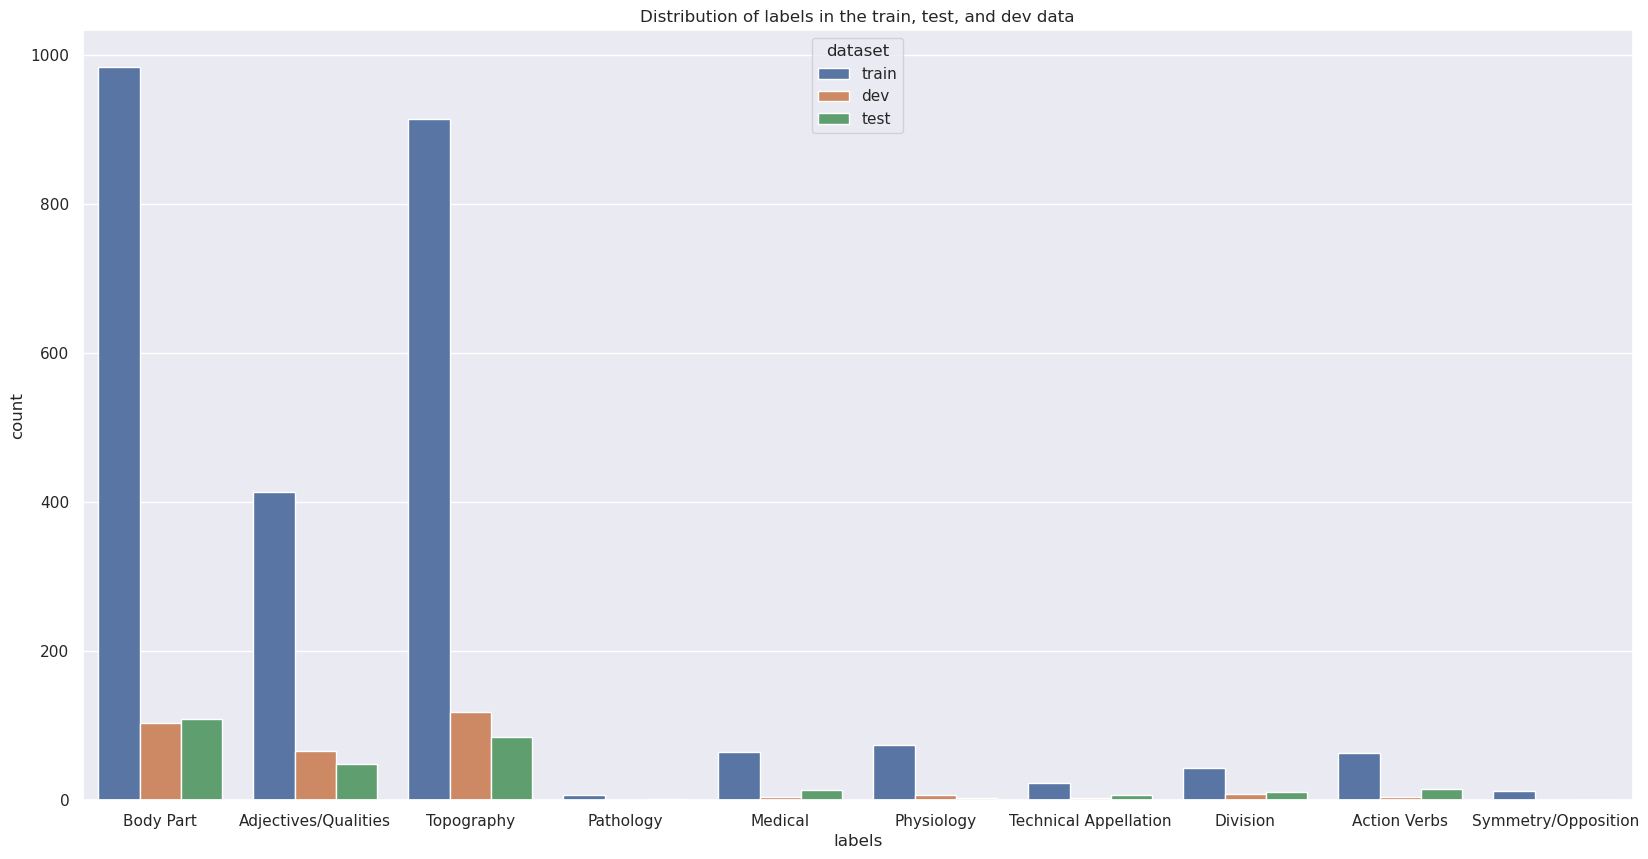

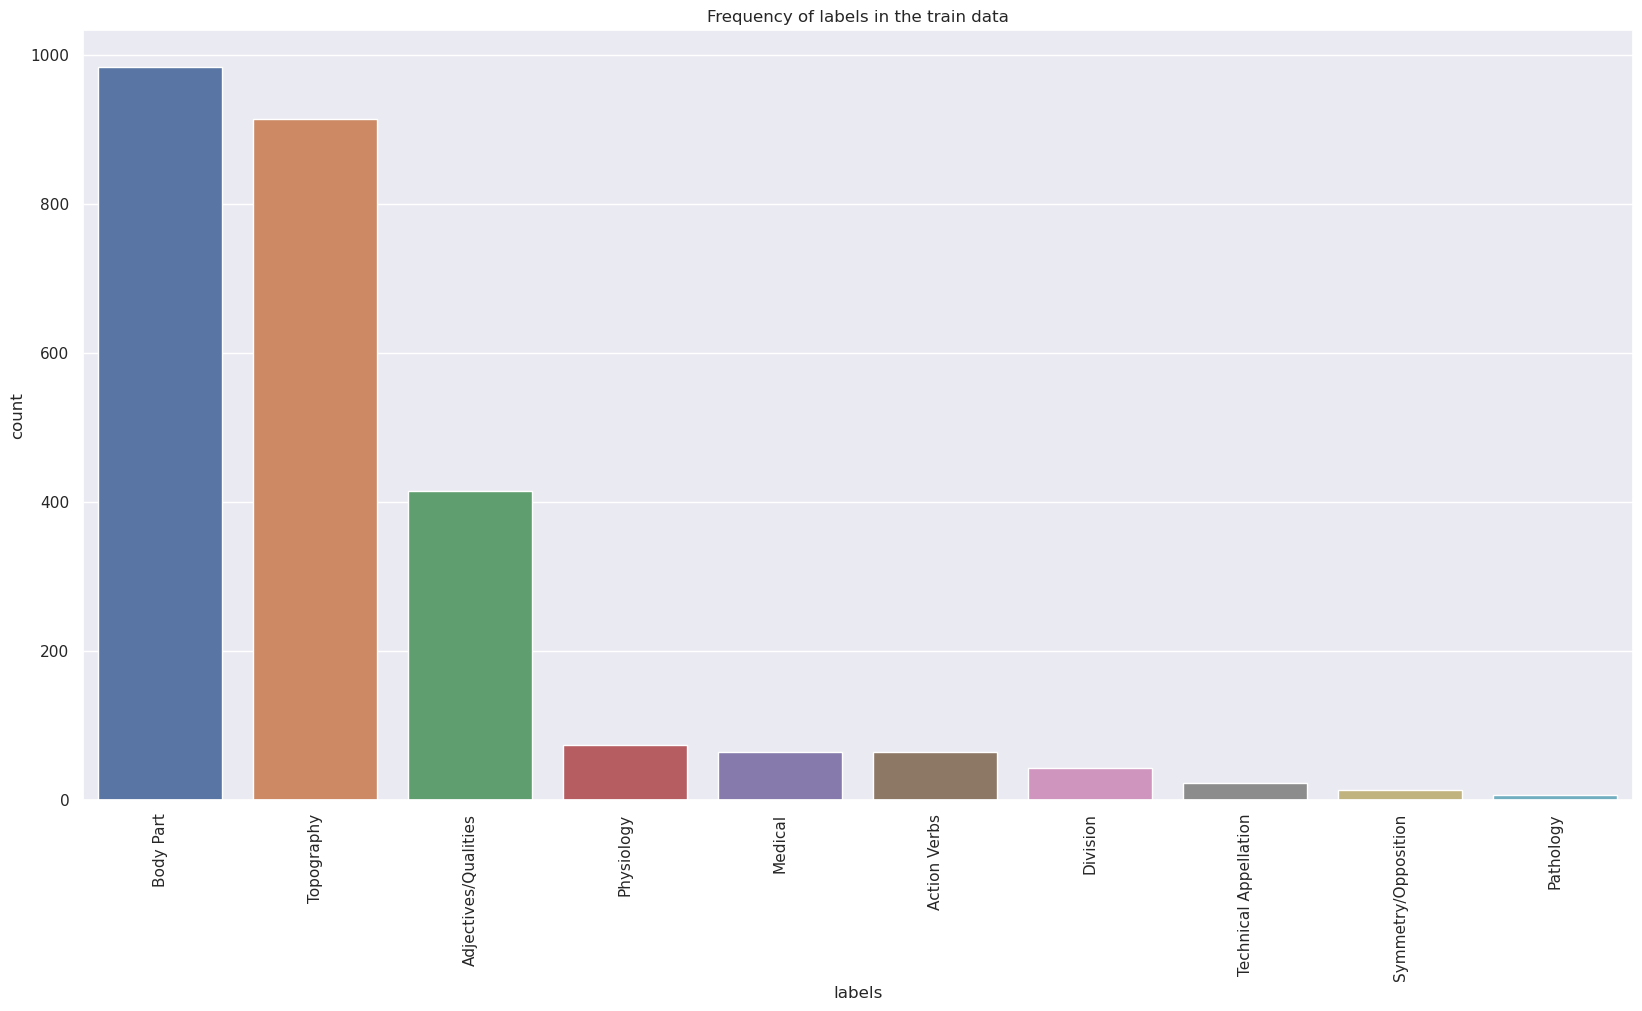

In [19]:
train_docs, dev_docs, test_docs = visualize_label_distribution(nlp, form='NFKD')

In [20]:
from spacy.tokens import DocBin

# load a docbin
test_doc_bin_nfkc = DocBin().from_disk("../corpus/train/ner_train/ner_train_NFKC.spacy")
test_doc_bin_nfkd = DocBin().from_disk("../corpus/train/ner_train/ner_train_NFKD.spacy")
test_docs_nfkc = list(test_doc_bin_nfkc.get_docs(nlp.vocab))
test_docs_nfkd = list(test_doc_bin_nfkd.get_docs(nlp.vocab))

def print_user_data_for_label(docs, label):
    for doc in docs:
        # Check if the doc contains an entity with the specified label
        if any(ent.label_ == label for ent in doc.ents):
            print("doc user data: ", doc.user_data)

In [21]:
print_user_data_for_label(test_docs_nfkc, "Action verb")

                   Label  Count
0              Body Part    984
1             Topography    914
2   Adjectives/Qualities    414
3             Physiology     74
4                Medical     65
5           Action Verbs     64
6               Division     43
7  Technical Appellation     23
8    Symmetry/Opposition     13
9              Pathology      7


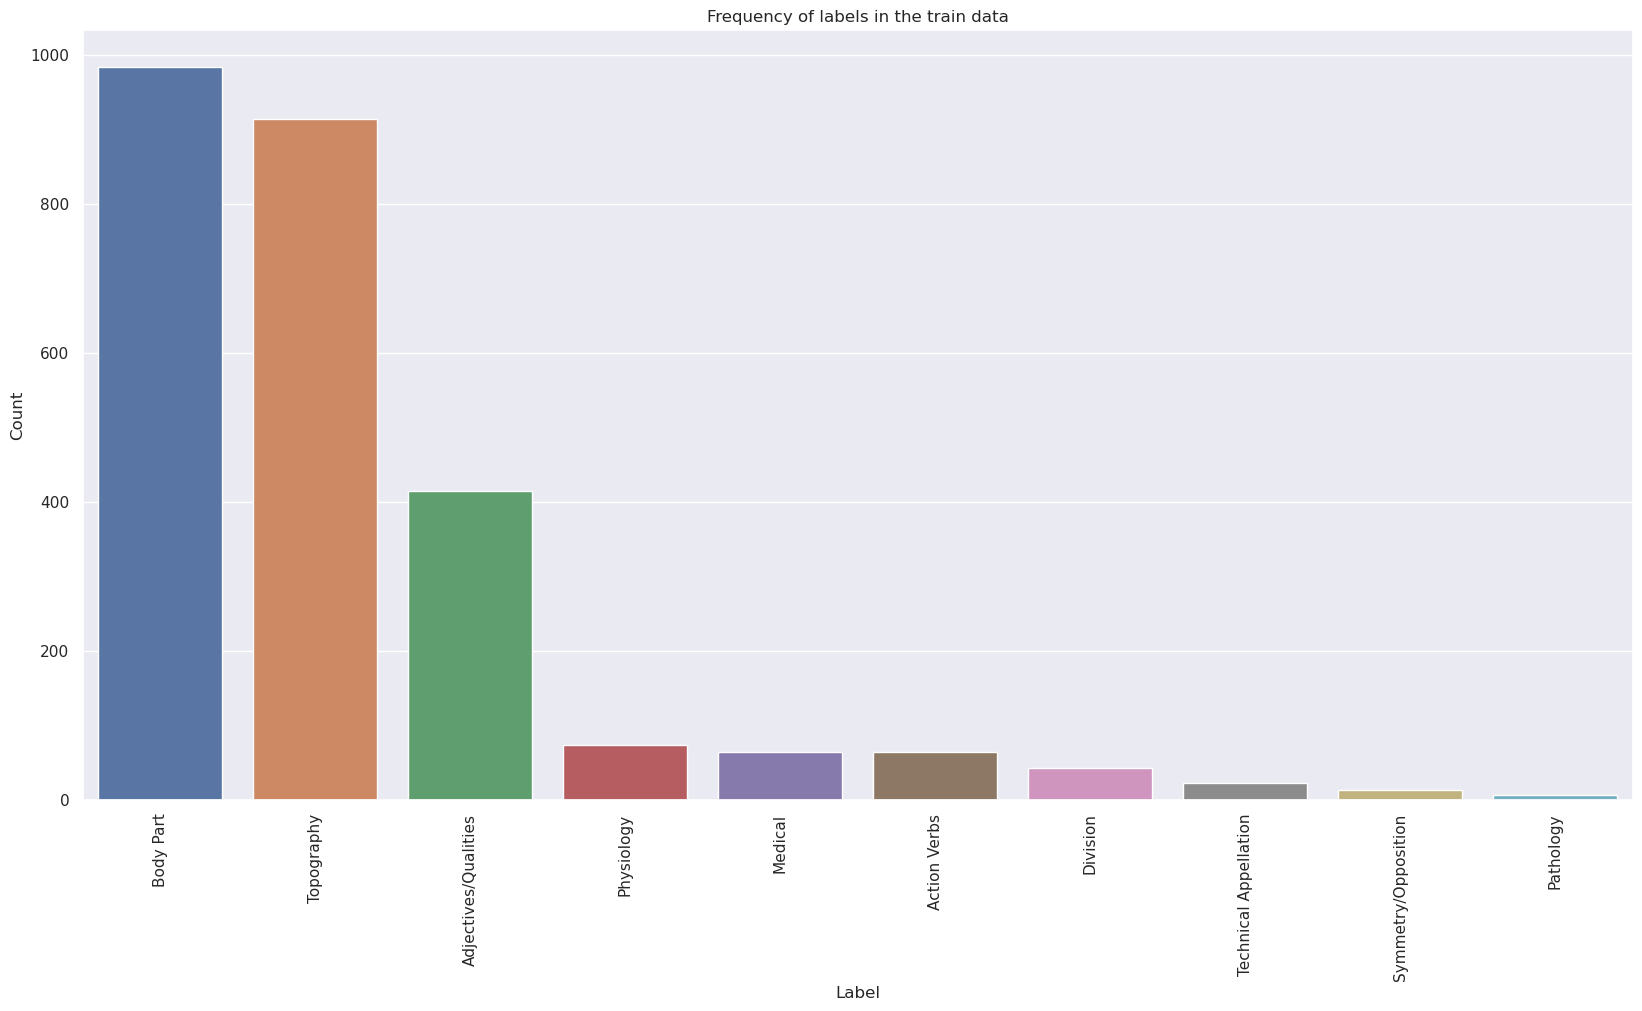

In [22]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extract labels from the training data
train_data_labels = [ent.label_ for docs in train_docs for ent in docs.ents]

# Convert the list of labels into a DataFrame
train_data_labels = pd.DataFrame(train_data_labels, columns=['labels'])

# Count the frequency of each label
train_data_labels = train_data_labels['labels'].value_counts()

# Convert the Series object into a DataFrame and reset the index
train_data_labels = pd.DataFrame(train_data_labels).reset_index()

# Rename the columns for better understanding
train_data_labels.columns = ['Label', 'Count']

# Print the DataFrame
print(train_data_labels)

# Plot the frequency of each label
plt.figure(figsize=(20,10))
sns.barplot(data=train_data_labels, x='Label', y='Count')
plt.title("Frequency of labels in the train data")
plt.xticks(rotation=90)
plt.show()

In [23]:
# load the train, test and dev data
#import spacy
#from spacy.tokens import DocBin
#nlp = spacy.load("grc_proiel_trf")
FORMAT = 'NFKD'
train_docbin = DocBin().from_disk("../corpus/train/ner_train/ner_train_{0}.spacy".format(FORMAT))
# get docs from new_docbin
train_docs = list(train_docbin.get_docs(nlp.vocab))
dev_docbin = DocBin().from_disk("../corpus/dev/ner_dev/ner_dev_{0}.spacy".format(FORMAT))
# get docs from new_docbin
dev_docs = list(dev_docbin.get_docs(nlp.vocab))
test_docbin = DocBin().from_disk("../corpus/test/ner_test/ner_test_{0}.spacy".format(FORMAT))
# get docs from new_docbin
test_docs = list(test_docbin.get_docs(nlp.vocab))
# count sentences in train, test and dev data
print ("train:", len(train_docs), "dev:", len(dev_docs), "test:", len(test_docs))


train: 406 dev: 51 test: 51


In [24]:
# load the train, test and dev data
#import spacy
#from spacy.tokens import DocBin
#nlp = spacy.load("grc_proiel_trf")
FORMAT = 'NFKC'
train_docbin = DocBin().from_disk("../corpus/train/ner_train/ner_train_{0}.spacy".format(FORMAT))
# get docs from new_docbin
train_docs = list(train_docbin.get_docs(nlp.vocab))
dev_docbin = DocBin().from_disk("../corpus/dev/ner_dev/ner_dev_{0}.spacy".format(FORMAT))
# get docs from new_docbin
dev_docs = list(dev_docbin.get_docs(nlp.vocab))
test_docbin = DocBin().from_disk("../corpus/test/ner_test/ner_test_{0}.spacy".format(FORMAT))
# get docs from new_docbin
test_docs = list(test_docbin.get_docs(nlp.vocab))
# count sentences in train, test and dev data
print ("train:", len(train_docs), "dev:", len(dev_docs), "test:", len(test_docs))
# find sentence "διακοπεῖσα δὲ οὐδʼ ἡ κύστις συμφύεται ἀλλʼ ἢ παρʼ αὐτὴν τὴν ἀρχὴν τοῦ οὐρητῆρος, εἰ μή τι πάμπαν σπάνιον" and print ents for tokens
for doc in train_docs:
    if doc.text == "τὴν μὲν γὰρ καρδίην ἴδοις ἂν ῥιπταζομένην οὐλομελῆ, τὰ δὲ οὔατα κατʼ ἰδίην ἀναφυσώμενά τε καὶ ξυμπίπτοντα.":
        print("doc user data: ", doc.user_data)
        for ent in doc.ents:
            print(ent.text, ent.start_char, ent.end_char, ent.label_)



train: 406 dev: 51 test: 51
doc user data:  {'source_info': 'Hippocratic_De corde Part B chs 5-9'}
καρδίην 12 19 Body Part
ῥιπταζομένην 29 41 Physiology
οὐλομελῆ 42 50 Physiology
οὔατα 58 63 Body Part
κατʼ 64 68 Topography
ἰδίην 69 74 Physiology
ἀναφυσώμενά 75 86 Physiology
ξυμπίπτοντα 94 105 Physiology


In [25]:
# debug ner data in spacy
import random
# sample random from train_docs
doc = random.choice(train_docs)
print (doc.text)
for ent in doc.ents:
    print (ent.text, ent.label_)
print ("Spacy entities, for line:")
print (doc.text)
print([(ent.text, ent.label_) for ent in doc.ents])


προχωρῶν δʼ ἐπὶ τὰ πλάγια παρὰ τὰς νόθας πλευράς, εἰ μὴ προσέχοις τὸν νοῦν, διασπάσεις [οἷον] τὴν κεφαλὴν τοῦ μικροῦ μυός, ὃν εἰς τὴν μασχάλην ἔλεγον ἀναφέρεσθαι λαθόντα τοὺς ἀνατομικούς.
πλάγια Topography
τὰς νόθας πλευράς Medical
διασπάσεις Action Verbs
μικροῦ Adjectives/Qualities
μυός Body Part
μασχάλην Body Part
Spacy entities, for line:
προχωρῶν δʼ ἐπὶ τὰ πλάγια παρὰ τὰς νόθας πλευράς, εἰ μὴ προσέχοις τὸν νοῦν, διασπάσεις [οἷον] τὴν κεφαλὴν τοῦ μικροῦ μυός, ὃν εἰς τὴν μασχάλην ἔλεγον ἀναφέρεσθαι λαθόντα τοὺς ἀνατομικούς.
[('πλάγια', 'Topography'), ('τὰς νόθας πλευράς', 'Medical'), ('διασπάσεις', 'Action Verbs'), ('μικροῦ', 'Adjectives/Qualities'), ('μυός', 'Body Part'), ('μασχάλην', 'Body Part')]


In [26]:
from IPython.display import Markdown, display

def print_words_at_indices(sentence, entities, source):
    for start, end, label in entities:
        word = sentence[start:end]
        display(Markdown(sentence[:start] + f"**[{word}]**" + sentence[end:]))
        print(f"Word: {word}, Label: {label}, Source: {source}")

# Example usage:
# Assuming TRAIN_DATA2 is already defined and is not empty.
#sentence, entities_dict = TRAIN_DATA[207]  # Get the first sentence and its entities.
#entities = entities_dict['entities']  # Get the list of entity tuples.
#print_words_at_indices(sentence, entities)
sentence, entities_dict, source = MERGED_TRAIN_DATA[252]  # Get the first sentence and its entities.
entities = entities_dict['entities']  # Get the list of entity tuples.
print_words_at_indices(sentence, entities, source)

καί σοι τοῦτʼ ἔσται μέγιστον γνώρισμα τοῦ **[τετμῆσθαι]** καλώς.

Word: τετμῆσθαι, Label: Action Verbs, Source: Gal. AA. 5, 7, 313, 28 - 315, 19
